In [2]:
# Import Packages and libraries required

import pandas as pd
import numpy as np
import tensorflow as tf
import folium
from folium import plugins
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import copy
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import GridSearchCV
import shap 
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import math
from sklearn.metrics import mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from itertools import cycle
import matplotlib.cm as cm
from geopy.geocoders import Nominatim
from geopy.distance import distance as gd
import pyproj
import requests
from openrouteservice import client
from shapely import geometry
from shapely.geometry import Point, LineString, Polygon, MultiPolygon

In [3]:
# Importing the data
crash_data = pd.read_csv('C:/Users/mural/Desktop/Traffic dataset/Updated ones/Traffic_Crashes_-_Crashes.csv',low_memory=False)
vehicle_data = pd.read_csv('C:/Users/mural/Desktop/Traffic dataset/Updated ones/Traffic_Crashes_-_Vehicles.csv',low_memory=False)
people_data = pd.read_csv('C:/Users/mural/Desktop/Traffic dataset/Updated ones/Traffic_Crashes_-_People.csv',low_memory=False)

In [4]:
# Merging the common columns
info1 = np.intersect1d(people_data.columns,(np.intersect1d(crash_data.columns, vehicle_data.columns)))
info2 = np.intersect1d(crash_data.columns, vehicle_data.columns)
info3 = np.intersect1d(people_data.columns, vehicle_data.columns)
print(info1,info2,info3)

['CRASH_DATE' 'CRASH_RECORD_ID' 'RD_NO'] ['CRASH_DATE' 'CRASH_RECORD_ID' 'RD_NO'] ['CRASH_DATE' 'CRASH_RECORD_ID' 'RD_NO' 'VEHICLE_ID']


In [5]:
# Converting the CRASH_DATE column to datetime data type

crash_data['CRASH_DATE'] = pd.to_datetime(crash_data['CRASH_DATE'])
vehicle_data['CRASH_DATE'] = pd.to_datetime(vehicle_data['CRASH_DATE'])
people_data['CRASH_DATE'] = pd.to_datetime(people_data['CRASH_DATE'])

In [6]:
# The 2021 data is only filtered 
Final_crash_data = crash_data[(crash_data['CRASH_DATE'] >= '2021-01-01') & (crash_data['CRASH_DATE'] <= '2021-12-31')]
Final_vehicle_data = vehicle_data[(vehicle_data['CRASH_DATE'] >= '2021-01-01') & (vehicle_data['CRASH_DATE'] <= '2021-12-31')]
Final_people_data = people_data[(people_data['CRASH_DATE'] >= '2021-01-01') & (people_data['CRASH_DATE'] <= '2021-12-31')]

In [7]:
# The values are merged using the common columns 
merged = pd.merge(left=Final_vehicle_data, right = Final_crash_data,left_on=['CRASH_RECORD_ID','RD_NO','CRASH_DATE'], right_on=["CRASH_RECORD_ID",'RD_NO','CRASH_DATE'])
merged_data = pd.merge(left=Final_people_data, right=merged,left_on = ['VEHICLE_ID','CRASH_RECORD_ID','RD_NO','CRASH_DATE'],right_on=['VEHICLE_ID','CRASH_RECORD_ID','RD_NO','CRASH_DATE'])


In [8]:
nulls = merged_data.isna().sum()
null_percent = nulls[nulls>0] / len(merged_data)
null_percent.to_frame('% Null').style.background_gradient(cmap='Blues')

,% Null
VEHICLE_ID,0.021553
SEAT_NO,0.801246
CITY,0.295012
STATE,0.282818
ZIPCODE,0.358507
SEX,0.016684
AGE,0.307975
DRIVERS_LICENSE_STATE,0.431188
DRIVERS_LICENSE_CLASS,0.544756
SAFETY_EQUIPMENT,0.003146


In [9]:
# extracting columns with missing values greater than 70%
Index_label = null_percent[null_percent>.70].index.tolist()

In [10]:
# Creating another variable which drops the columns in Index_label
merged_data_1 = merged_data.drop(columns = Index_label)

## AIM OF THE RESEARCH IS

### A) Predicting severity of a traffic accident
### B) Predicting factors which determine the severity of traffic accidents
### C) Provide Safer Route Based on the accident and Road Traffic Violation

In [11]:
# Creating a new variable 
severity_accident = copy.deepcopy(merged_data_1)

# A) Predicting severity of a traffic crashes

In [12]:
merged_data_1

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,RD_NO,VEHICLE_ID,CRASH_DATE,CITY,STATE,ZIPCODE,SEX,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,O1241639,DRIVER,3af0e3ff1ea95965ea3be467aa58d0e74de4f9b11320be...,JE469682,1178465.0,2021-12-07 21:08:00,NaN,NaN,NaN,M,...,0.0,0.0,1.0,0.0,21,3,12,41.909977,-87.755823,POINT (-87.755822648009 41.909977009294)
1,O1123822,DRIVER,5f37bc99d63afdb5a967b8ac29c993bed6b1d36c705618...,JE267929,1065982.0,2021-06-16 09:00:00,MCCOOK,IL,NaN,M,...,0.0,1.0,0.0,0.0,9,4,6,41.797395,-87.684273,POINT (-87.684272963451 41.797394747543)
2,O1250197,DRIVER,5d274b762c8fd736979d9c0cf8e28e59769a0816325059...,JE484633,1186661.0,2021-12-21 08:05:00,CHICAGO,IL,NaN,M,...,0.0,0.0,3.0,0.0,8,3,12,41.894049,-87.622999,POINT (-87.62299852501 41.894049259418)
3,P279567,PASSENGER,5d274b762c8fd736979d9c0cf8e28e59769a0816325059...,JE484633,1186661.0,2021-12-21 08:05:00,CHICAGO,IL,NaN,F,...,0.0,0.0,3.0,0.0,8,3,12,41.894049,-87.622999,POINT (-87.62299852501 41.894049259418)
4,O1250198,DRIVER,7c1633882168a5b91e14b5be272a0e87a87bccb432c226...,JE484649,1186663.0,2021-12-21 10:20:00,WORTH,IL,60482,M,...,0.0,0.0,2.0,0.0,10,3,12,41.905033,-87.746172,POINT (-87.746171786063 41.905032966964)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238063,O1341429,DRIVER,df4716667eeb453ca863773e69851e46f3aca8f26ab28a...,JE242636,1274390.0,2021-05-25 16:45:00,CHICAGO,IL,60651,M,...,1.0,0.0,1.0,0.0,16,3,5,41.874004,-87.676602,POINT (-87.676602341069 41.874003638416)
238064,O1343576,DRIVER,9491cc7a634ea35bc964df252b396b2299cef1730a45d7...,JE334725,1276489.0,2021-08-11 10:30:00,HAZEL CREST,IL,60429,F,...,0.0,0.0,2.0,0.0,10,4,8,41.751638,-87.564871,POINT (-87.564871437929 41.751638437521)
238065,O1343577,DRIVER,9491cc7a634ea35bc964df252b396b2299cef1730a45d7...,JE334725,1276490.0,2021-08-11 10:30:00,CHICAGO,IL,60629,M,...,0.0,0.0,2.0,0.0,10,4,8,41.751638,-87.564871,POINT (-87.564871437929 41.751638437521)
238066,O1350809,DRIVER,7c2c0d0d38d34ba1630b9ce3d34206de5a91880f797764...,JE214054,1283428.0,2021-04-29 15:29:00,CHICAGO,IL,60652,F,...,0.0,0.0,2.0,0.0,15,5,4,41.721478,-87.650694,POINT (-87.650694262037 41.721478236557)


In [13]:
# Removing interdependent columns
drop_list_1 = ['AREA_01_I','AREA_12_I']
severity_accident.drop(columns = drop_list_1, inplace = True)

In [14]:
# Removing columns with inconclusive details and lot of values similar to null

drop_list_2 = ['BAC_RESULT','EJECTION', 
            'BEAT_OF_OCCURRENCE','SEC_CONTRIBUTORY_CAUSE','REPORT_TYPE','VEHICLE_DEFECT']

severity_accident.drop(columns = drop_list_2, inplace = True)

#### Removing Null Values and Replacing them with neccessry values

In [15]:
#Removing Null and 0 values in the location 
severity_accident = severity_accident.dropna(subset=['LATITUDE','LONGITUDE','LOCATION'],axis=0)
severity_accident.dropna(subset=['LATITUDE', 'LONGITUDE','LOCATION'])
severity_accident.drop(severity_accident[severity_accident['LATITUDE']==0.0].index, inplace = True)

In [16]:
# Filling the Null values for HIT_AND_RUN_I

severity_accident.fillna({
    'HIT_AND_RUN_I':'N'
}, inplace=True)
severity_accident['HIT_AND_RUN_I'] = severity_accident.HIT_AND_RUN_I.replace({'Y':'1','N':'0'})

In [17]:
# Filling the Null values for SEX

severity_accident.fillna({
    'SEX':'X'
}, inplace=True)
severity_accident['SEX']

0         M
1         M
2         M
3         F
4         M
         ..
238063    M
238064    F
238065    M
238066    F
238067    F
Name: SEX, Length: 236258, dtype: object

In [18]:
# Filling the Null values for SAFETY_EQUIPMENT

severity_accident.fillna({
    'SAFETY_EQUIPMENT':'USAGE UNKNOWN'
}, inplace=True)
severity_accident['SAFETY_EQUIPMENT'].value_counts()

USAGE UNKNOWN                                 117819
SAFETY BELT USED                              104979
NONE PRESENT                                    7616
HELMET NOT USED                                 1521
SAFETY BELT NOT USED                            1136
CHILD RESTRAINT - FORWARD FACING                 909
BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)       654
CHILD RESTRAINT - TYPE UNKNOWN                   437
CHILD RESTRAINT - REAR FACING                    402
DOT COMPLIANT MOTORCYCLE HELMET                  276
BOOSTER SEAT                                     240
CHILD RESTRAINT NOT USED                          73
NOT DOT COMPLIANT MOTORCYCLE HELMET               60
SHOULD/LAP BELT USED IMPROPERLY                   54
WHEELCHAIR                                        44
CHILD RESTRAINT USED IMPROPERLY                   16
STRETCHER                                          9
HELMET USED                                        9
CHILD RESTRAINT USED                          

In [19]:
# Filling the Null values for AIRBAG_DEPLOYED

severity_accident.fillna({
    'AIRBAG_DEPLOYED':'DEPLOYMENT UNKNOWN'
}, inplace=True)
severity_accident['AIRBAG_DEPLOYED'].value_counts()

DID NOT DEPLOY                            99026
NOT APPLICABLE                            61492
DEPLOYMENT UNKNOWN                        55738
DEPLOYED, FRONT                            9193
DEPLOYED, COMBINATION                      7987
DEPLOYED, SIDE                             2667
DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)      155
Name: AIRBAG_DEPLOYED, dtype: int64

In [20]:
# Filling the Null values for DRIVER_VISION

severity_accident.fillna({
    'DRIVER_VISION':'UNKNOWN'
}, inplace=True)
severity_accident['DRIVER_VISION'].value_counts()

UNKNOWN                   144567
NOT OBSCURED               87259
OTHER                       1882
MOVING VEHICLES             1000
PARKED VEHICLES              693
WINDSHIELD (WATER/ICE)       437
BLINDED - SUNLIGHT           214
TREES, PLANTS                 88
BUILDINGS                     53
BLINDED - HEADLIGHTS          20
EMBANKMENT                    18
HILLCREST                     15
BLOWING MATERIALS              9
SIGNBOARD                      3
Name: DRIVER_VISION, dtype: int64

In [21]:
# Filling the Null values for UNIT_TYPE

severity_accident.UNIT_TYPE.fillna(severity_accident.PERSON_TYPE,inplace=True)
severity_accident['UNIT_TYPE'].value_counts()

severity_accident.UNIT_TYPE

0         DRIVER
1         DRIVER
2         DRIVER
3         DRIVER
4         DRIVER
           ...  
238063    DRIVER
238064    DRIVER
238065    DRIVER
238066    DRIVER
238067    DRIVER
Name: UNIT_TYPE, Length: 236258, dtype: object

In [22]:
# Filling the Null values for VEHICLE_TYPE

severity_accident.fillna({
    'VEHICLE_TYPE':'UNKNOWN/NA'
}, inplace=True)

severity_accident['VEHICLE_TYPE'].value_counts()

PASSENGER                                 143746
SPORT UTILITY VEHICLE (SUV)                33938
UNKNOWN/NA                                 26549
VAN/MINI-VAN                               10161
PICKUP                                      7177
TRUCK - SINGLE UNIT                         4128
OTHER                                       3041
BUS OVER 15 PASS.                           2938
TRACTOR W/ SEMI-TRAILER                     1900
BUS UP TO 15 PASS.                           892
SINGLE UNIT TRUCK WITH TRAILER               569
MOTORCYCLE (OVER 150CC)                      547
OTHER VEHICLE WITH TRAILER                   248
TRACTOR W/O SEMI-TRAILER                     199
MOPED OR MOTORIZED BICYCLE                   123
ALL-TERRAIN VEHICLE (ATV)                     49
AUTOCYCLE                                     19
3-WHEELED MOTORCYCLE (2 REAR WHEELS)          17
FARM EQUIPMENT                                 8
RECREATIONAL OFF-HIGHWAY VEHICLE (ROV)         8
MOTOR DRIVEN CYCLE  

In [23]:
# Checking the Column Values to check if there have values that are Missing, Reduntant values or Values that cannot be converted

for columns in severity_accident.columns:
    print(columns,'\n',severity_accident[columns].value_counts())
    print('\n')
    print('Total Null Values: ',severity_accident[columns].isna().sum())
    print('\n')
print('\n') 

PERSON_ID 
 O1049256    5
O1049257    5
O1090857    4
O1067829    4
O1085042    4
           ..
P230709     1
O1133884    1
O1133792    1
O1133920    1
O1350810    1
Name: PERSON_ID, Length: 235578, dtype: int64


Total Null Values:  0


PERSON_TYPE 
 DRIVER                 184314
PASSENGER               46995
PEDESTRIAN               2984
BICYCLE                  1770
NON-MOTOR VEHICLE         159
NON-CONTACT VEHICLE        36
Name: PERSON_TYPE, dtype: int64


Total Null Values:  0


CRASH_RECORD_ID 
 ab683b4b18b6cc083b300ac34333e19e6f57b5a23b09d86524928d694ffe347a5aef5f9bf840aa4128ce389e4f234374560a08fe5ade4bdd69eb485d8c9165bd    28
ec14b8a3d84d0302ca0761d6e5ecc1c2dc335f8802f83a7c01b5141d8fffa5cb27d96b1e98207f2fa4f586acca7fdea268c41e7a51b3b4431a3d42c8f2238ed4    26
43bf767af796b06222eae2d7619dcd6ad0f144178da641010ad66c4b8b1ddc9f4e327c14d1e8a5db2c7bbe0662c31ceb61216f21684c69fea5473e8d90d6cb76    24
7e4048aa331ab03ec78f74e94e881ad33d776bc812a50005ce0aa4523ba2eb0087d89f0b70c46221dd39eba

Total Null Values:  0


NUM_PASSENGERS 
 1.0     45192
2.0     17367
3.0      8867
4.0      3691
5.0      1077
6.0       535
7.0       230
10.0       87
8.0        45
19.0       40
12.0       39
9.0        30
26.0       27
24.0       25
22.0       23
18.0       19
17.0       18
11.0       12
Name: NUM_PASSENGERS, dtype: int64


Total Null Values:  158934


MAKE 
 CHEVROLET                         27764
UNKNOWN                           23430
FORD                              23406
TOYOTA                            22932
NISSAN                            19005
                                  ...  
BOMBARDIER                            1
NATIONAL MOBILE HOMES                 1
KENSILL TRAILER CORPORATION           1
PONYCYCLE                             1
ALEXANDER-REYNOLDS CORPORATION        1
Name: MAKE, Length: 437, dtype: int64


Total Null Values:  5093


MODEL 
 OTHER (EXPLAIN IN NARRATIVE)                      41178
CAMRY                                              6355
MOTORIZ

Total Null Values:  0


LIGHTING_CONDITION 
 DAYLIGHT                  152535
DARKNESS, LIGHTED ROAD     56717
DARKNESS                    9215
UNKNOWN                     7487
DUSK                        6720
DAWN                        3584
Name: LIGHTING_CONDITION, dtype: int64


Total Null Values:  0


FIRST_CRASH_TYPE 
 REAR END                        57767
TURNING                         40955
SIDESWIPE SAME DIRECTION        38357
PARKED MOTOR VEHICLE            33659
ANGLE                           33427
FIXED OBJECT                     7477
PEDESTRIAN                       5469
SIDESWIPE OPPOSITE DIRECTION     3890
REAR TO FRONT                    3810
PEDALCYCLIST                     3595
HEAD ON                          2869
REAR TO SIDE                     2267
OTHER OBJECT                     1396
REAR TO REAR                      770
OTHER NONCOLLISION                309
OVERTURNED                        124
ANIMAL                            102
TRAIN                      

In [24]:
# Removing columns that are Reduntant and values that cannot be converted as categorical

drop_list_3 = ['UNIT_NO',
 'VEHICLE_ID',
 'VEHICLE_USE',
 'VEHICLE_YEAR',
 'ZIPCODE','FIRST_CONTACT_POINT',
 'INJURY_CLASSIFICATION',
 'LIC_PLATE_STATE',
'DRIVERS_LICENSE_STATE',
'DRIVERS_LICENSE_CLASS',
 'MAKE',
 'MANEUVER',
 'MODEL',
 'NUM_PASSENGERS',
 'OCCUPANT_CNT',
 'PERSON_ID',
 'PERSON_TYPE',
 'PHYSICAL_CONDITION',
 'STATE','DATE_POLICE_NOTIFIED','TRAVEL_DIRECTION',
 'DRIVER_ACTION','CITY','AGE','CRASH_UNIT_ID']
severity_accident.drop(columns = drop_list_3, inplace = True)

# Feature Engineering and Changing columns Names

In [25]:
# Feature Engineering the column season using the month column
month_bins = [0,4,7,10,13]
label=('Winter','Spring','Summer','Fall')
month_binned = pd.cut(severity_accident['CRASH_MONTH'], month_bins, labels= label)
month_binned= month_binned.cat.as_unordered()
severity_accident['SEASON'] = month_binned

In [26]:
# Removing Further Columns by after feature engineering

severity_accident['STREET_NO'] = (severity_accident['STREET_NO']).astype(str)
severity_accident['STREET_DIRECTION'] = (severity_accident['STREET_DIRECTION']).astype(str)
severity_accident['STREET_NAME'] = (severity_accident['STREET_NAME']).astype(str)

In [27]:
# Removing after columns after creating address
severity_accident['ADDRESS'] = severity_accident[['STREET_NO', 'STREET_DIRECTION', 'STREET_NAME']].agg(' '.join, axis=1)
severity_accident.drop(['STREET_NO','STREET_DIRECTION','STREET_NAME'],axis=1, inplace = True)

In [28]:
# Changing the Target Varible which is to identify as the severity of the accident

severity_accident.rename(columns = {'CRASH_TYPE': 'SEVERE'}, inplace = True)
severity_accident['SEVERE'] = severity_accident.SEVERE.replace({'INJURY AND / OR TOW DUE TO CRASH':'1','NO INJURY / DRIVE AWAY':'0'})
severity_accident['SEVERE'].value_counts()

0    152787
1     83471
Name: SEVERE, dtype: int64

In [29]:
# Duplicating anoother variable

severity_accident_clean = copy.deepcopy(severity_accident)

# Grouping the values of the categorical variables for one hot encoding

### Creating bins and label


### POSTED_SPEED_RANGE

In [30]:
# creating bins and label, previewing data 
severity_accident_clean['POSTED_SPEED_RANGE'] = pd.cut(x=severity_accident_clean['POSTED_SPEED_LIMIT'], bins = [-1,15,25,40,75], 
                         labels = ['0-15', '16-25', 
                        '26-40', '41+'])
list(severity_accident_clean.POSTED_SPEED_RANGE.unique())

['26-40', '16-25', '41+', '0-15']

### Weather Condtion

In [31]:
## Grouping columns values that are similar

severity_accident_clean.WEATHER_CONDITION.value_counts()
severity_accident_clean.WEATHER_CONDITION.unique()

weather_map = {'CLEAR': 'CLEAR',
                'RAIN': 'RAIN/CLOUDY',               
                'CLOUDY/OVERCAST': 'RAIN/CLOUDY',
               'FREEZING RAIN/DRIZZLE': 'RAIN/CLOUDY',
               'SLEET/HAIL': 'RAIN/CLOUDY', 
               'FOG/SMOKE/HAZE': 'RAIN/CLOUDY',
               'SEVERE CROSS WIND GATE': 'RAIN/CLOUDY',
               'UNKNOWN': 'SNOW/OTHER',
                'OTHER ': 'SNOW/OTHER',
               'SNOW':'SNOW/OTHER',
               'BLOWING SNOW':'SNOW/OTHER'               
                }
severity_accident_clean.WEATHER_CONDITION = severity_accident_clean.WEATHER_CONDITION.replace(weather_map)
severity_accident_clean.WEATHER_CONDITION.value_counts()

CLEAR          191077
RAIN/CLOUDY     25970
SNOW/OTHER      18510
OTHER             701
Name: WEATHER_CONDITION, dtype: int64

### Roadway condition

In [32]:
## Grouping columns values that are similar
severity_accident_clean['ROADWAY_SURFACE_COND'] =severity_accident_clean['ROADWAY_SURFACE_COND'].replace({'UNKNOWN':'UNKNOWN/OTHER',
                                                                 'OTHER':'UNKNOWN/OTHER',
                                                               'SAND, MUD, DIRT': 'UNKNOWN/OTHER',
                                                                 'ICE': 'SNOW OR SLUSH'})
severity_accident_clean['ROADWAY_SURFACE_COND'].value_counts()

DRY              179406
WET               28470
UNKNOWN/OTHER     17605
SNOW OR SLUSH     10777
Name: ROADWAY_SURFACE_COND, dtype: int64

### Traffic Control Device

In [33]:
## Grouping columns values that are similar
severity_accident_clean.TRAFFIC_CONTROL_DEVICE.value_counts()
severity_accident_clean.TRAFFIC_CONTROL_DEVICE.unique()


traffic_control_map =  {'NO CONTROLS': 'NO CONTROLS',}
traffic_control_map.update(dict.fromkeys(['TRAFFIC SIGNAL','STOP SIGN/FLASHER','OTHER WARNING SIGN','PEDESTRIAN CROSSING SIGN',
                                          'OTHER REG. SIGN','FLASHING CONTROL SIGNAL','RR CROSSING SIGN','BICYCLE CROSSING SIGN']
                                         ,'TRAFFIC SIGNAL/SIGN'))
traffic_control_map.update(dict.fromkeys(['UNKNOWN','SCHOOL ZONE','YIELD', 'OTHER','DELINEATORS','RAILROAD CROSSING GATE','OTHER RAILROAD CROSSING',
                                         'POLICE/FLAGMAN','NO PASSING'],'UNKNOWN/OTHER'))

traffic_control_map



severity_accident_clean.TRAFFIC_CONTROL_DEVICE = severity_accident_clean.TRAFFIC_CONTROL_DEVICE.replace(traffic_control_map) 


severity_accident_clean.TRAFFIC_CONTROL_DEVICE.value_counts()

NO CONTROLS            120244
TRAFFIC SIGNAL/SIGN    105993
UNKNOWN/OTHER           10021
Name: TRAFFIC_CONTROL_DEVICE, dtype: int64

### Road Defect

In [34]:
## Grouping columns values that are similar
road_defect_map = {'NO DEFECTS': 'NO DEFECTS',
              'RUT, HOLES':'DEFECT/OTHER',
              'SHOULDER DEFECT': 'DEFECT/OTHER',
              'DEBRIS ON ROADWAY': 'DEFECT/OTHER', 
              'WORN SURFACE': 'DEFECT/OTHER',
              'OTHER': 'DEFECT/OTHER',
                'UNKNOWN': 'UNKNOWN',
                }
severity_accident_clean.ROAD_DEFECT = severity_accident_clean.ROAD_DEFECT.replace(road_defect_map)
severity_accident_clean.ROAD_DEFECT.value_counts()

NO DEFECTS      190656
UNKNOWN          41980
DEFECT/OTHER      3622
Name: ROAD_DEFECT, dtype: int64

### Trafficway Type

In [35]:
## Grouping columns values that are similar
trafficway_map = {'NOT DIVIDED': 'NOT DIVIDED',
                'DIVIDED - W/MEDIAN (NOT RAISED)': 'DIVIDED',
                'ONE-WAY': 'ONE-WAY',
                'FOUR WAY': 'FOUR WAY',
                'PARKING LOT': 'PARKING LOT',
                'DIVIDED - W/MEDIAN BARRIER': 'DIVIDED',
                'ALLEY': 'ALLEY/LANE/INTERSECTION/OTHER',
                'OTHER': 'ALLEY/LANE/INTERSECTION/OTHER',
                'CENTER TURN LANE':'ALLEY/LANE/INTERSECTION/OTHER', 
                'Y-INTERSECTION': 'ALLEY/LANE/INTERSECTION/OTHER',
                'T-INTERSECTION': 'ALLEY/LANE/INTERSECTION/OTHER',
                  'L-INTERSECTION' : 'ALLEY/LANE/INTERSECTION/OTHER', 
                 'TRAFFIC ROUTE': 'ALLEY/LANE/INTERSECTION/OTHER',
                  'RAMP': 'ALLEY/LANE/INTERSECTION/OTHER',
                  'FIVE POINT, OR MORE': 'ALLEY/LANE/INTERSECTION/OTHER',
                 'DRIVEWAY': 'ALLEY/LANE/INTERSECTION/OTHER',
                  'ROUNDABOUT': 'ALLEY/LANE/INTERSECTION/OTHER',
                'UNKNOWN': 'UNKNOWN',
                'NOT REPORTED': 'UNKNOWN',
                'UNKNOWN INTERSECTION TYPE': 'UNKNOWN'}
# Should be done only once, i.e while running the program for the first time
severity_accident_clean.TRAFFICWAY_TYPE = severity_accident_clean.TRAFFICWAY_TYPE.replace(trafficway_map)
severity_accident_clean.TRAFFICWAY_TYPE.value_counts()

NOT DIVIDED                      101428
DIVIDED                           50796
FOUR WAY                          26794
ONE-WAY                           23303
ALLEY/LANE/INTERSECTION/OTHER     18450
PARKING LOT                       11620
UNKNOWN                            3867
Name: TRAFFICWAY_TYPE, dtype: int64

### First Crash Type

In [36]:
crash_map = {'PEDESTRIAN': 'PED/CYCLIST',
                'PEDALCYCLIST': 'PED/CYCLIST',
                'REAR END': 'REAR END',
                'SIDESWIPE SAME DIRECTION': 'SIDESWIPE',
             'SIDESWIPE OPPOSITE DIRECTION': 'SIDESWIPE',             
                'TURNING': 'TURNING/ANGLE',
                'ANGLE': 'TURNING/ANGLE',
                'PARKED MOTOR VEHICLE': 'PARKED/FIXED',
                'FIXED OBJECT': 'PARKED/FIXED',                
                'REAR TO FRONT':'REAR TO (FRONT/SIDE/REAR)',
                 'REAR TO SIDE': 'REAR TO (FRONT/SIDE/REAR)',
                 'REAR TO REAR': 'REAR TO (FRONT/SIDE/REAR)',
                'OVERTURNED': 'OTHER',
                'ANIMAL': 'OTHER',
                'HEAD ON': 'OTHER',
                'OTHER OBJECT': 'OTHER',                
                'OTHER NONCOLLISION': 'OTHER',
             'TRAIN':'OTHER'}
len(crash_map)

# Should be done only once, i.e while running the program for the first time
severity_accident_clean.FIRST_CRASH_TYPE = severity_accident_clean.FIRST_CRASH_TYPE.replace(crash_map)
severity_accident_clean.FIRST_CRASH_TYPE.value_counts()

TURNING/ANGLE                74382
REAR END                     57767
SIDESWIPE                    42247
PARKED/FIXED                 41136
PED/CYCLIST                   9064
REAR TO (FRONT/SIDE/REAR)     6847
OTHER                         4815
Name: FIRST_CRASH_TYPE, dtype: int64

In [37]:
severity_accident_clean.VEHICLE_TYPE.value_counts()
vehicle_map = {'PASSENGER': 'PASSENGER',
                'SPORT UTILITY VEHICLE (SUV)': 'SUV/VAN/PICKUP',
                'UNKNOWN/NA': 'UNKNOWN/NA',
                'VAN/MINI-VAN': 'SUV/VAN/PICKUP',
                'PICKUP': 'SUV/VAN/PICKUP',                
                'TRACTOR W/ SEMI-TRAILER': 'BUS/TRUCK/TRAILER',
                'TRUCK - SINGLE UNIT': 'BUS/TRUCK/TRAILER',
                'BUS UP TO 15 PASS.': 'BUS/TRUCK/TRAILER',
                'BUS OVER 15 PASS.': 'BUS/TRUCK/TRAILER',
                'SINGLE UNIT TRUCK WITH TRAILER': 'BUS/TRUCK/TRAILER',
               'OTHER VEHICLE WITH TRAILER':'BUS/TRUCK/TRAILER',
               'OTHER': 'OTHER',
                'MOTORCYCLE (OVER 150CC)': 'OTHER',
                'TRACTOR W/O SEMI-TRAILER': 'OTHER',
                'MOPED OR MOTORIZED BICYCLE': 'OTHER',
                'AUTOCYCLE': 'OTHER',
                'ALL-TERRAIN VEHICLE (ATV)': 'OTHER',
               'FARM EQUIPMENT': 'OTHER',
                '3-WHEELED MOTORCYCLE (2 REAR WHEELS)': 'OTHER',
                'RECREATIONAL OFF-HIGHWAY VEHICLE (ROV)': 'OTHER',  
               'SNOWMOBILE': 'OTHER'
              }
# Should be done only once, i.e while running the program for the first time
severity_accident_clean.VEHICLE_TYPE = severity_accident_clean.VEHICLE_TYPE.replace(vehicle_map)
severity_accident_clean.VEHICLE_TYPE.value_counts()

PASSENGER             143746
SUV/VAN/PICKUP         51276
UNKNOWN/NA             26549
BUS/TRUCK/TRAILER      10675
OTHER                   4011
MOTOR DRIVEN CYCLE         1
Name: VEHICLE_TYPE, dtype: int64

In [38]:
safety_map = {'USAGE UNKNOWN': 'USAGE UNKNOWN',
                'SAFETY BELT USED': 'SAFETY EQUIPMENT USED',
                'NONE PRESENT': 'NONE PRESENT/NOT USED',
                'BICYCLE HELMET (PEDACYCLIST INVOLVED ONLY)': 'SAFETY EQUIPMENT USED',
                'HELMET NOT USED': 'NONE PRESENT/NOT USED',
                'SAFETY BELT NOT USED': 'NONE PRESENT/NOT USED',
                'DOT COMPLIANT MOTORCYCLE HELMET ': 'SAFETY EQUIPMENT USED',
                'CHILD RESTRAINT - FORWARD FACING': 'SAFETY EQUIPMENT USED',
                'CHILD RESTRAINT - REAR FACING': 'SAFETY EQUIPMENT USED',
                'CHILD RESTRAINT - TYPE UNKNOWN': 'SAFETY EQUIPMENT USED',
              'CHILD RESTRAINT USED': 'SAFETY EQUIPMENT USED',
                'SHOULD/LAP BELT USED IMPROPERLY': 'NONE PRESENT/NOT USED',
             'BOOSTER SEAT':'OTHERS',
 'CHILD RESTRAINT NOT USED':'NONE PRESENT/NOT USED',
 'CHILD RESTRAINT USED':'SAFETY EQUIPMENT USED',
 'CHILD RESTRAINT USED IMPROPERLY':'NONE PRESENT/NOT USED',
 'DOT COMPLIANT MOTORCYCLE HELMET':'NONE PRESENT/NOT USED',
 'HELMET USED':'SAFETY EQUIPMENT USED',
 'NOT DOT COMPLIANT MOTORCYCLE HELMET':'OTHERS',
 'STRETCHER':'OTHERS',
 'WHEELCHAIR':'OTHERS'}

# Should be done only once, i.e while running the program for the first time
severity_accident_clean.SAFETY_EQUIPMENT = severity_accident_clean.SAFETY_EQUIPMENT.replace(safety_map)
severity_accident_clean.SAFETY_EQUIPMENT.value_counts()

USAGE UNKNOWN            117819
SAFETY EQUIPMENT USED    107394
NONE PRESENT/NOT USED     10692
OTHERS                      353
Name: SAFETY_EQUIPMENT, dtype: int64

In [39]:
# defining dictionary map and remapping
airbag_map = {'DID NOT DEPLOY': 'DID NOT DEPLOY',
                'NOT APPLICABLE': 'NOT APPLICABLE/UNKNOWN',
                'DEPLOYMENT UNKNOWN': 'NOT APPLICABLE/UNKNOWN',
                'DEPLOYED, FRONT': 'DEPLOYED',
                'DEPLOYED, COMBINATION': 'DEPLOYED',
                'DEPLOYED, SIDE': 'DEPLOYED',
                'DEPLOYED OTHER (KNEE, AIR, BELT, ETC.)': 'DEPLOYED'}

# Should be done only once, i.e while running the program for the first time
severity_accident_clean.AIRBAG_DEPLOYED = severity_accident_clean.AIRBAG_DEPLOYED.replace(airbag_map)
severity_accident_clean.AIRBAG_DEPLOYED.value_counts()

NOT APPLICABLE/UNKNOWN    117230
DID NOT DEPLOY             99026
DEPLOYED                   20002
Name: AIRBAG_DEPLOYED, dtype: int64

In [40]:
# defining dictionary map and remapping
driver_map = {'NOT OBSCURED': 'NOT OBSCURED',
                'UNKNOWN': 'UNKNOWN',
                'OTHER': 'OBSCURED',
                'PARKED VEHICLES': 'OBSCURED',
                'MOVING VEHICLES': 'OBSCURED',
                'BLINDED - SUNLIGHT': 'OBSCURED',
             'BLINDED - HEADLIGHTS': 'OBSCURED',
 'BLOWING MATERIALS': 'OBSCURED',
 'BUILDINGS': 'OBSCURED',
 'EMBANKMENT': 'OBSCURED',
 'HILLCREST': 'OBSCURED',
 'SIGNBOARD': 'OBSCURED',
 'TREES, PLANTS': 'OBSCURED',
 'WINDSHIELD (WATER/ICE)': 'OBSCURED'}

# Should be done only once, i.e while running the program for the first time
severity_accident_clean.DRIVER_VISION = severity_accident_clean.DRIVER_VISION.replace(driver_map)

severity_accident_clean.DRIVER_VISION.value_counts()

UNKNOWN         144567
NOT OBSCURED     87259
OBSCURED          4432
Name: DRIVER_VISION, dtype: int64

In [41]:
(severity_accident_clean.isna().sum())

CRASH_RECORD_ID                  0
RD_NO                            0
CRASH_DATE                       0
SEX                              0
SAFETY_EQUIPMENT                 0
AIRBAG_DEPLOYED                  0
DRIVER_VISION                    0
UNIT_TYPE                        0
VEHICLE_TYPE                     0
POSTED_SPEED_LIMIT               0
TRAFFIC_CONTROL_DEVICE           0
DEVICE_CONDITION                 0
WEATHER_CONDITION                0
LIGHTING_CONDITION               0
FIRST_CRASH_TYPE                 0
TRAFFICWAY_TYPE                  0
ALIGNMENT                        0
ROADWAY_SURFACE_COND             0
ROAD_DEFECT                      0
SEVERE                           0
HIT_AND_RUN_I                    0
DAMAGE                           0
PRIM_CONTRIBUTORY_CAUSE          0
NUM_UNITS                        0
MOST_SEVERE_INJURY               0
INJURIES_TOTAL                   0
INJURIES_FATAL                   0
INJURIES_INCAPACITATING          0
INJURIES_NON_INCAPAC

## EXPLORATORY DATA ANALYSIS

In [42]:
max_week = severity_accident_clean.CRASH_DAY_OF_WEEK[max(severity_accident_clean.CRASH_DAY_OF_WEEK.value_counts())]
max_hr = severity_accident_clean.CRASH_HOUR[max(severity_accident_clean.CRASH_HOUR.value_counts())]
max_mt = severity_accident_clean.CRASH_MONTH[max(severity_accident_clean.CRASH_MONTH.value_counts())]

Maximum accidents is on the 6 th day of the week with a count of 39211


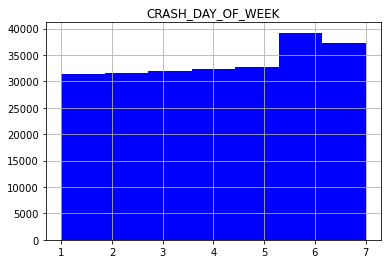

In [43]:
print('Maximum accidents is on the',max_week-1,'th day of the week with a count of',max(severity_accident_clean.CRASH_DAY_OF_WEEK.value_counts()))
severity_accident_clean.hist('CRASH_DAY_OF_WEEK',bins=7,layout=(1,1),color = "blue",sharey=True,sharex=True);

Maximum accidents is on Hour: 16 with a count of 19518


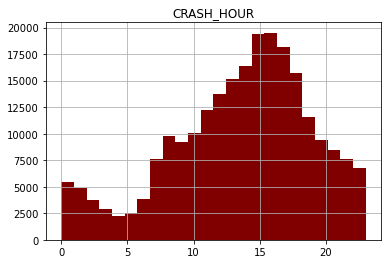

In [44]:
print('Maximum accidents is on Hour:',max_hr-1,'with a count of',max(severity_accident_clean.CRASH_HOUR.value_counts()))
severity_accident_clean.hist('CRASH_HOUR',bins=24,layout=(1,1),color = "maroon",sharey=True,sharex=True);

Maximum accidents is on Month 3 with a count of 22905


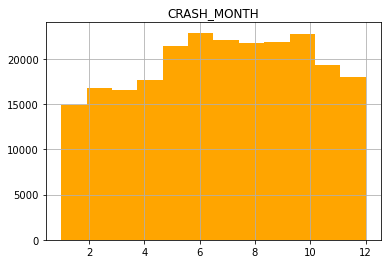

In [45]:
print('Maximum accidents is on Month',max_mt-1,'with a count of',max(severity_accident_clean.CRASH_MONTH.value_counts()))
severity_accident_clean.hist('CRASH_MONTH',bins=12,layout=(1,1),color = "orange",sharey=True,sharex=True);

## Converting variables into categorical as they need to be converted into Dummies

In [46]:
severity_accident_clean[['TRAFFIC_CONTROL_DEVICE','DEVICE_CONDITION', 'WEATHER_CONDITION', 
         'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE' , 'TRAFFICWAY_TYPE', 
         'ROADWAY_SURFACE_COND', 'ALIGNMENT','SEASON',
         'ROAD_DEFECT', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE','UNIT_TYPE','VEHICLE_TYPE','SEX',
            'SAFETY_EQUIPMENT','AIRBAG_DEPLOYED','DRIVER_VISION','POSTED_SPEED_RANGE']] = severity_accident_clean[['TRAFFIC_CONTROL_DEVICE','DEVICE_CONDITION', 'WEATHER_CONDITION', 
         'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE' , 'TRAFFICWAY_TYPE', 
         'ROADWAY_SURFACE_COND', 'ALIGNMENT','SEASON',
         'ROAD_DEFECT', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE','UNIT_TYPE','VEHICLE_TYPE','SEX',
            'SAFETY_EQUIPMENT','AIRBAG_DEPLOYED','DRIVER_VISION','POSTED_SPEED_RANGE']].astype('category')

In [47]:
#creating the dummies
dummies_V2=['TRAFFIC_CONTROL_DEVICE','DEVICE_CONDITION', 'WEATHER_CONDITION', 
         'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 
         'ROADWAY_SURFACE_COND', 'ALIGNMENT','SEASON','SEX',
         'ROAD_DEFECT', 'DAMAGE', 'PRIM_CONTRIBUTORY_CAUSE','UNIT_TYPE','VEHICLE_TYPE',
            'SAFETY_EQUIPMENT','AIRBAG_DEPLOYED','DRIVER_VISION','POSTED_SPEED_RANGE']
severity_accident_clean_dm =  pd.get_dummies(severity_accident_clean, columns = dummies_V2, drop_first = False )

In [48]:
# Removing Further columns after feature engineering or they are no longer needed for analysis
drop_list = ['POSTED_SPEED_LIMIT', 'RD_NO','CRASH_RECORD_ID','INJURIES_UNKNOWN',
             'MOST_SEVERE_INJURY']
severity_accident_clean_dm.drop(columns = drop_list, inplace = True)

## Model Implementation for Severity

In [49]:
# Define Input and Target Variables
Target = severity_accident_clean_dm['SEVERE']
# Removing 'Severe' as it is the output and other variables as it contains non numerical values
Input = severity_accident_clean_dm.drop(columns=['SEVERE','CRASH_DATE','LOCATION','ADDRESS'], axis=1)

In [50]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [51]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(Input, Target, random_state=10)
print('Training data')
print(y_train.value_counts())
print('\nTesting data')
print(y_test.value_counts())
X_train

Training data
0    114551
1     62642
Name: SEVERE, dtype: int64

Testing data
0    38236
1    20829
Name: SEVERE, dtype: int64


,HIT_AND_RUN_I,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,TRAFFIC_CONTROL_DEVICE_NO CONTROLS,TRAFFIC_CONTROL_DEVICE_TRAFFIC SIGNAL/SIGN,TRAFFIC_CONTROL_DEVICE_UNKNOWN/OTHER,DEVICE_CONDITION_FUNCTIONING IMPROPERLY,DEVICE_CONDITION_FUNCTIONING PROPERLY,DEVICE_CONDITION_MISSING,DEVICE_CONDITION_NO CONTROLS,DEVICE_CONDITION_NOT FUNCTIONING,DEVICE_CONDITION_OTHER,DEVICE_CONDITION_UNKNOWN,DEVICE_CONDITION_WORN REFLECTIVE MATERIAL,WEATHER_CONDITION_CLEAR,WEATHER_CONDITION_OTHER,WEATHER_CONDITION_RAIN/CLOUDY,WEATHER_CONDITION_SNOW/OTHER,LIGHTING_CONDITION_DARKNESS,"LIGHTING_CONDITION_DARKNESS, LIGHTED ROAD",LIGHTING_CONDITION_DAWN,LIGHTING_CONDITION_DAYLIGHT,LIGHTING_CONDITION_DUSK,LIGHTING_CONDITION_UNKNOWN,FIRST_CRASH_TYPE_OTHER,FIRST_CRASH_TYPE_PARKED/FIXED,FIRST_CRASH_TYPE_PED/CYCLIST,FIRST_CRASH_TYPE_REAR END,FIRST_CRASH_TYPE_REAR TO (FRONT/SIDE/REAR),FIRST_CRASH_TYPE_SIDESWIPE,FIRST_CRASH_TYPE_TURNING/ANGLE,TRAFFICWAY_TYPE_ALLEY/LANE/INTERSECTION/OTHER,TRAFFICWAY_TYPE_DIVIDED,TRAFFICWAY_TYPE_FOUR WAY,TRAFFICWAY_TYPE_NOT DIVIDED,TRAFFICWAY_TYPE_ONE-WAY,TRAFFICWAY_TYPE_PARKING LOT,TRAFFICWAY_TYPE_UNKNOWN,ROADWAY_SURFACE_COND_DRY,ROADWAY_SURFACE_COND_SNOW OR SLUSH,...,PRIM_CONTRIBUTORY_CAUSE_FAILING TO REDUCE SPEED TO AVOID CRASH,PRIM_CONTRIBUTORY_CAUSE_FAILING TO YIELD RIGHT-OF-WAY,PRIM_CONTRIBUTORY_CAUSE_FOLLOWING TOO CLOSELY,PRIM_CONTRIBUTORY_CAUSE_HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE),PRIM_CONTRIBUTORY_CAUSE_IMPROPER BACKING,PRIM_CONTRIBUTORY_CAUSE_IMPROPER LANE USAGE,PRIM_CONTRIBUTORY_CAUSE_IMPROPER OVERTAKING/PASSING,PRIM_CONTRIBUTORY_CAUSE_IMPROPER TURNING/NO SIGNAL,PRIM_CONTRIBUTORY_CAUSE_NOT APPLICABLE,PRIM_CONTRIBUTORY_CAUSE_OBSTRUCTED CROSSWALKS,"PRIM_CONTRIBUTORY_CAUSE_OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER",PRIM_CONTRIBUTORY_CAUSE_PASSING STOPPED SCHOOL BUS,PRIM_CONTRIBUTORY_CAUSE_PHYSICAL CONDITION OF DRIVER,PRIM_CONTRIBUTORY_CAUSE_RELATED TO BUS STOP,PRIM_CONTRIBUTORY_CAUSE_ROAD CONSTRUCTION/MAINTENANCE,PRIM_CONTRIBUTORY_CAUSE_ROAD ENGINEERING/SURFACE/MARKING DEFECTS,PRIM_CONTRIBUTORY_CAUSE_TEXTING,PRIM_CONTRIBUTORY_CAUSE_TURNING RIGHT ON RED,PRIM_CONTRIBUTORY_CAUSE_UNABLE TO DETERMINE,PRIM_CONTRIBUTORY_CAUSE_UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED),"PRIM_CONTRIBUTORY_CAUSE_VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)",PRIM_CONTRIBUTORY_CAUSE_WEATHER,UNIT_TYPE_BICYCLE,UNIT_TYPE_DISABLED VEHICLE,UNIT_TYPE_DRIVER,UNIT_TYPE_DRIVERLESS,UNIT_TYPE_NON-CONTACT VEHICLE,UNIT_TYPE_NON-MOTOR VEHICLE,UNIT_TYPE_PARKED,UNIT_TYPE_PEDESTRIAN,VEHICLE_TYPE_BUS/TRUCK/TRAILER,VEHICLE_TYPE_MOTOR DRIVEN CYCLE,VEHICLE_TYPE_OTHER,VEHICLE_TYPE_PASSENGER,VEHICLE_TYPE_SUV/VAN/PICKUP,VEHICLE_TYPE_UNKNOWN/NA,SAFETY_EQUIPMENT_NONE PRESENT/NOT USED,SAFETY_EQUIPMENT_OTHERS,SAFETY_EQUIPMENT_SAFETY EQUIPMENT USED,SAFETY_EQUIPMENT_USAGE UNKNOWN,AIRBAG_DEPLOYED_DEPLOYED,AIRBAG_DEPLOYED_DID NOT DEPLOY,AIRBAG_DEPLOYED_NOT APPLICABLE/UNKNOWN,DRIVER_VISION_NOT OBSCURED,DRIVER_VISION_OBSCURED,DRIVER_VISION_UNKNOWN,POSTED_SPEED_RANGE_0-15,POSTED_SPEED_RANGE_16-25,POSTED_SPEED_RANGE_26-40,POSTED_SPEED_RANGE_41+
12849,1,4,1.0,0.0,0.0,1.0,0.0,7.0,13,1,2,41.750055,-87.682992,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0
77060,0,3,0.0,0.0,0.0,0.0,0.0,3.0,10,6,6,41.780405,-87.596879,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0
189359,0,2,0.0,0.0,0.0,0.0,0.0,1.0,2,5,10,41.996989,-87.796526,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1

## Logistic Regression

In [52]:
# Creating the Logistic classifier, and fitting it on the training data to make predictions on the testing data
logreg = LogisticRegression(C=1e10)
logreg.fit(X_train, y_train)

LogisticRegression(C=10000000000.0)

In [53]:
# Predicting tesing data using logreg
logreg_prediction = logreg.predict(X_test)

In [54]:
# probabilit for each values

pred_prob_log = logreg.predict_proba(X_test)[:,1]
pred_prob_log

array([0.9995581 , 0.69210251, 0.1369188 , ..., 0.47505612, 0.1833869 ,
       0.02493141])

In [55]:
#printing classifiction report of logistic regression
print('Classification Report for Logistic Regression\n')
print(classification_report(y_test, logreg_prediction))

Classification Report for Logistic Regression

              precision    recall  f1-score   support

           0       0.86      0.98      0.91     38236
           1       0.94      0.70      0.80     20829

    accuracy                           0.88     59065
   macro avg       0.90      0.84      0.86     59065
weighted avg       0.89      0.88      0.87     59065



Predicted Results 
 [[37383   853]
 [ 6292 14537]]


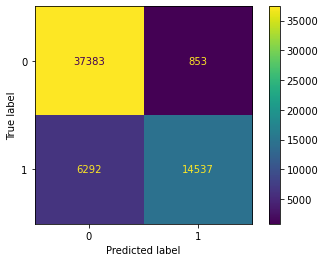

In [56]:
#printing the confusion matrix of Logistic regression
cm_log = confusion_matrix(y_test,logreg_prediction)
print('Predicted Results \n',cm_log)
mat_cm_log = plot_confusion_matrix(logreg,X_test,y_test); 
mat_cm_log;

## Decision Tree

In [57]:
# Creating the Decision Tree classifier, and fitting it on the training data to make predictions on the testing data

dtree_class = DecisionTreeClassifier()
dtree_class.fit(X_train, y_train)
dtree_prediction = dtree_class.predict(X_test)

In [58]:
# probability for each values
pred_prob_dt = dtree_class.predict_proba(X_test)[:,1]
pred_prob_dt

array([1., 1., 0., ..., 1., 0., 0.])

In [59]:
print('Classification Report for Decision Tree\n')
print(classification_report(y_test, dtree_prediction))

Classification Report for Decision Tree

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     38236
           1       0.89      0.90      0.90     20829

    accuracy                           0.93     59065
   macro avg       0.92      0.92      0.92     59065
weighted avg       0.93      0.93      0.93     59065



Predicted Results 
 [[36032  2204]
 [ 2099 18730]]


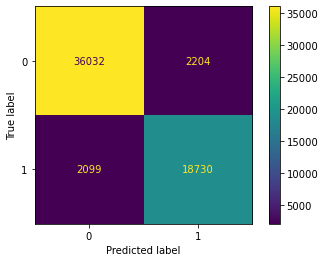

In [60]:
#printing the confusion matrix of Decision Tree Classifier
cm_dt = confusion_matrix(y_test,dtree_prediction)
print('Predicted Results \n',cm_dt)
mat_cm_dt =  plot_confusion_matrix(dtree_class,X_test,y_test);
mat_cm_dt;

## Random Forest Classifier

In [61]:
# Creating the Random Forest classifier, and fitting it on the training data to make predictions on the testing data
rf_class = RandomForestClassifier()
rf_class.fit(X_train,y_train)

RandomForestClassifier()

In [62]:
# Predicting tesing data using Random Forest

rf_class_prediction = rf_class.predict(X_test)

In [63]:
# probabilit for each values

pred_prob_rf = rf_class.predict_proba(X_test)[:,1]
pred_prob_rf

array([0.99, 0.99, 0.01, ..., 0.8 , 0.12, 0.  ])

In [64]:
#printing classifiction report of Random Forest
print('Classification Report for Random Forest Classifier \n')
print(classification_report(y_test, rf_class_prediction))

Classification Report for Random Forest Classifier 

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     38236
           1       0.97      0.84      0.90     20829

    accuracy                           0.93     59065
   macro avg       0.94      0.91      0.93     59065
weighted avg       0.94      0.93      0.93     59065



Predicted Results 
 [[37705   531]
 [ 3321 17508]]


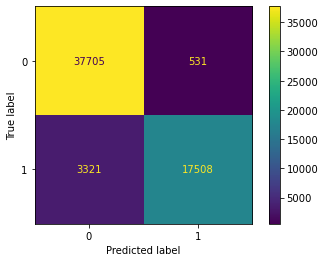

In [65]:
#printing the confusion matrix of Random Forest
cm_rf = confusion_matrix(y_test,rf_class_prediction)
print('Predicted Results \n',cm_rf)
mat_cm_rf = plot_confusion_matrix(rf_class,X_test,y_test);
mat_cm_rf;

## Overall Confusion Matrix

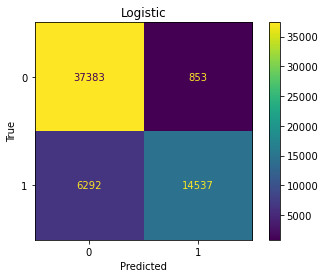

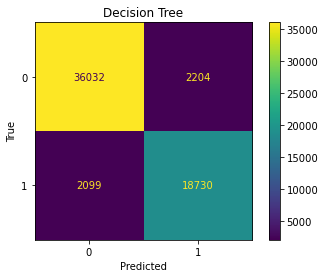

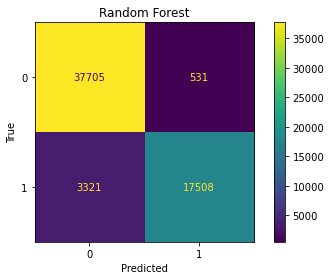

In [66]:
# Creating a Confusion Matrix of all the classifiers
class_mats = [mat_cm_log,mat_cm_dt,mat_cm_rf]
names = ['Logistic','Decision Tree','Random Forest']
count = 0
for i in class_mats:
    i.plot() 
    plt.title(names[count]);
    plt.grid(False);
    i.ax_.set(xlabel='Predicted', ylabel='True');    
    count=count+1
plt.tight_layout()
plt.show()

## Overall Classification Report

In [67]:
print('\t\t\t Logistic Regression: \n\n',classification_report( y_test, logreg_prediction))
print('\t\t\t Decision Tree \n\n',classification_report(y_test, dtree_prediction))
print('\t\t\t Random Forest \n\n',classification_report(y_test, rf_class_prediction))

			 Logistic Regression: 

               precision    recall  f1-score   support

           0       0.86      0.98      0.91     38236
           1       0.94      0.70      0.80     20829

    accuracy                           0.88     59065
   macro avg       0.90      0.84      0.86     59065
weighted avg       0.89      0.88      0.87     59065

			 Decision Tree 

               precision    recall  f1-score   support

           0       0.94      0.94      0.94     38236
           1       0.89      0.90      0.90     20829

    accuracy                           0.93     59065
   macro avg       0.92      0.92      0.92     59065
weighted avg       0.93      0.93      0.93     59065

			 Random Forest 

               precision    recall  f1-score   support

           0       0.92      0.99      0.95     38236
           1       0.97      0.84      0.90     20829

    accuracy                           0.93     59065
   macro avg       0.94      0.91      0.93     59065
weig

## ROC AUC for Logistic Regression

In [68]:
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn import metrics

# Converting the testing output to integer for graphical purpose
y_test_roc = y_test.astype('int')

In [69]:
# Logistic AUC and No Skill AUC

noskill = [0 for _ in range(len(y_test))]

Main_AUC_prob_log = roc_auc_score(y_test, pred_prob_log)
Noskill_AUC_log = roc_auc_score(y_test, noskill)
print('Logistic Regression ROC AUC : %.3f' % Main_AUC_prob_log)
print('No skill classifier ROC AUC: %.3f' % Noskill_AUC_log)
print('Accuracy : ',metrics.accuracy_score(y_test, dtree_prediction))

Logistic Regression ROC AUC : 0.929
No skill classifier ROC AUC: 0.500
Accuracy :  0.927148057225091


## ROC AUC for Decision Tree Classifier

In [70]:
# Decision Tree AUC and No Skill AUC

noskill = [0 for _ in range(len(y_test))]

Main_AUC_prob_dt = roc_auc_score(y_test, pred_prob_dt)
Noskill_AUC_dt = roc_auc_score(y_test, noskill)
print('Decision Tree Classifier  ROC AUC : %.3f' % Main_AUC_prob_dt)
print('No skill classifier ROC AUC: %.3f' % Noskill_AUC_dt)
print('Accuracy : ',metrics.accuracy_score(y_test, dtree_prediction))

Decision Tree Classifier  ROC AUC : 0.921
No skill classifier ROC AUC: 0.500
Accuracy :  0.927148057225091


## ROC AUC for Random Forest

In [71]:
# Random Forest AUC and No Skill AUC

noskill = [0 for _ in range(len(y_test))]

Main_AUC_prob_rf = roc_auc_score(y_test, pred_prob_rf)
Noskill_AUC_rf = roc_auc_score(y_test, noskill)
print('Random Forest ROC AUC : %.3f' % Main_AUC_prob_rf)
print('No skill classifier ROC AUC: %.3f' % Noskill_AUC_rf)
print('Accuracy : ',metrics.accuracy_score(y_test, rf_class_prediction))

Random Forest ROC AUC : 0.980
No skill classifier ROC AUC: 0.500
Accuracy :  0.934783712858715


AUC score for Logistic Regression: 0.9293799020856448
AUC score for Decision Tree Classifier: 0.9207925132306587
AUC score for Random Forest: 0.9799561026551039


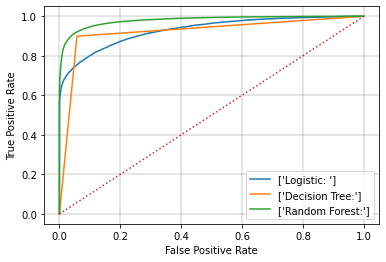

In [72]:
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test_roc, pred_prob_log)
fpr2, tpr2, thresholds2 = metrics.roc_curve(y_test_roc, pred_prob_dt)
fpr3, tpr3, thresholds3 = metrics.roc_curve(y_test_roc, pred_prob_rf)

print("AUC score for Logistic Regression:", roc_auc_score(y_test, pred_prob_log,average='macro'))
print("AUC score for Decision Tree Classifier:", roc_auc_score(y_test, pred_prob_dt,average='macro'))
print("AUC score for Random Forest:", roc_auc_score(y_test, pred_prob_rf,average='macro'))

auc1 = metrics.roc_auc_score(y_test, pred_prob_log)
auc2 = metrics.roc_auc_score(y_test, pred_prob_dt)
auc3 = metrics.roc_auc_score(y_test, pred_prob_rf)

plt.plot(fpr1, tpr1,label="AUC="+str(auc1))
plt.plot(fpr2, tpr2,label="AUC="+str(auc2))
plt.plot(fpr3, tpr3,label="AUC="+str(auc3))


plt.plot([0,1], [0,1], ls=':')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend([['Logistic: '], ['Decision Tree:'], ['Random Forest:']]) 

plt.grid(color='black', linestyle='-', linewidth=0.2);

# B) Predicting features which determine the severity of traffic accidents using GridSearch

## Grid Serach Decision Tree

In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
dtree_param_grid = {
    'max_depth' : [ 7,9],
    'min_samples_leaf' : [2, 5],
    'min_samples_split' : [2, 5 ],
    'class_weight' : ['balanced']
}

In [74]:
dtree_grids = GridSearchCV(estimator= DecisionTreeClassifier(), 
                          param_grid=dtree_param_grid, scoring = 'recall')

In [75]:
dtree_grids.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ['balanced'], 'max_depth': [7, 9],
                         'min_samples_leaf': [2, 5],
                         'min_samples_split': [2, 5]},
             scoring='recall')

In [76]:
dtree_grids.best_params_

{'class_weight': 'balanced',
 'max_depth': 7,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [77]:
dtree_grid_results_test = dtree_grids.predict(X_test)

In [78]:
print(classification_report(y_test, dtree_grid_results_test))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90     38236
           1       0.86      0.76      0.81     20829

    accuracy                           0.87     59065
   macro avg       0.87      0.85      0.86     59065
weighted avg       0.87      0.87      0.87     59065



In [79]:
best_dtree = dtree_grids.best_estimator_


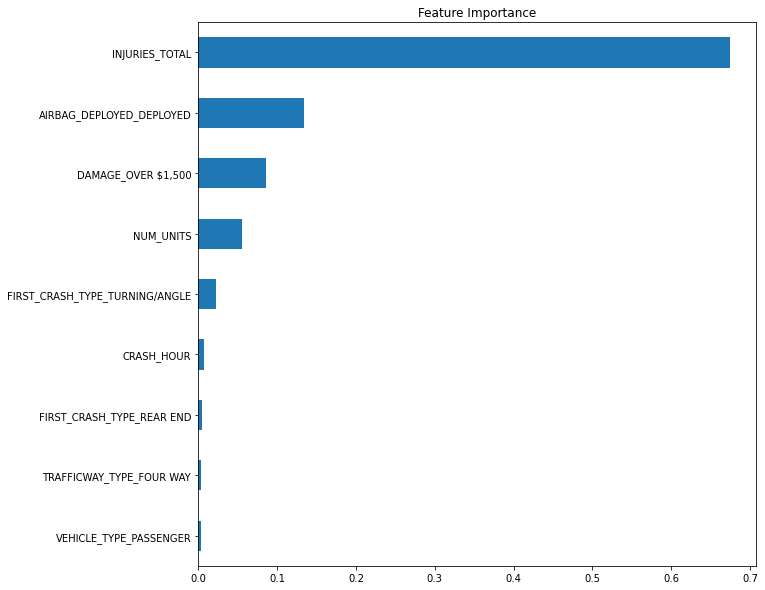

In [80]:
importance = pd.Series(best_dtree.feature_importances_ ,index=X_train.columns)
importance.sort_values().tail(9).plot(kind='barh', figsize=(10,10), title = 'Feature Importance');

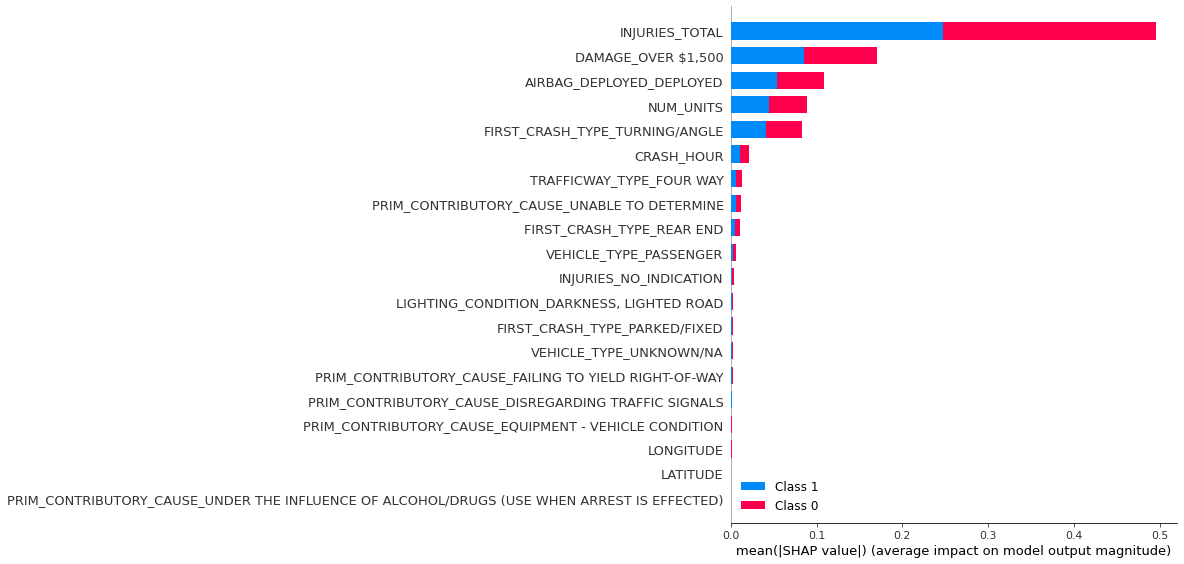

In [81]:
import shap 
Train_shap = shap.sample(X_train,10000)
TreeExplainer = shap.TreeExplainer(best_dtree)
shap_values = TreeExplainer.shap_values(Train_shap)
shap.summary_plot(shap_values, Train_shap, plot_type="bar");

### VISULIZATION TO EXPLAIN THE IMPORTANCE OF THE PARAMETER CHOSEN FOR THE RISK SCORE

In [82]:
pd.DataFrame(severity_accident.groupby(['INJURIES_FATAL','SEVERE']).CRASH_RECORD_ID.count())

CRASH_RECORD_ID
INJURIES_FATAL SEVERE                 
0.0            0                152787
               1                 82926
1.0            1                   497
2.0            1                    48

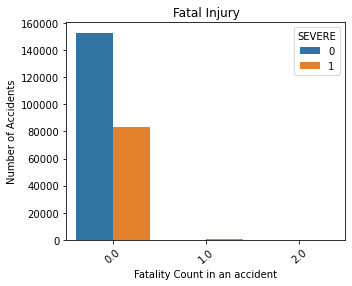

In [83]:
# counter plot of Fatal Injuries
plt.figure(figsize=(5,4))
sns.countplot(x="INJURIES_FATAL", data=severity_accident_clean, hue="SEVERE")
plt.title('Fatal Injury')
plt.xlabel('Fatality Count in an accident')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=40);

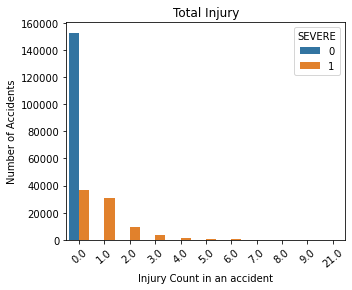

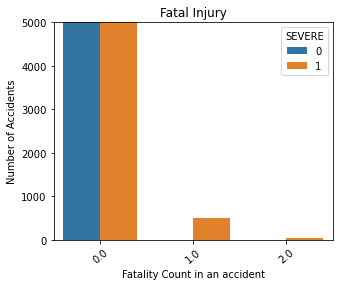

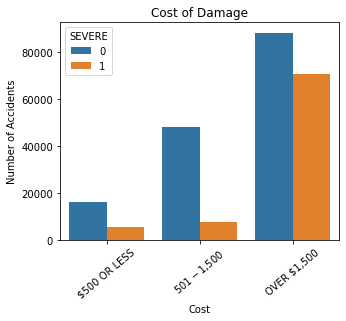

In [84]:
# counter plot of Total Injuries
plt.figure(figsize=(5,4))
sns.countplot(x="INJURIES_TOTAL", data=severity_accident_clean, hue="SEVERE")
plt.title('Total Injury')
plt.xlabel('Injury Count in an accident')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=40);
# counter plot of Fatal Injuries
plt.figure(figsize=(5,4))
sns.countplot(x="INJURIES_FATAL", data=severity_accident_clean, hue="SEVERE")
plt.title('Fatal Injury')
plt.xlabel('Fatality Count in an accident')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=40);
plt.ylim(0,5000);

# DAMAGE VS SEVERITY
plt.figure(figsize=(5,4))
sns.countplot(x="DAMAGE", data=severity_accident_clean, hue="SEVERE")
plt.title('Cost of Damage')
plt.xlabel('Cost')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=40);


In [85]:
pd.DataFrame(severity_accident.groupby(['INJURIES_TOTAL','SEVERE']).CRASH_RECORD_ID.count())

CRASH_RECORD_ID
INJURIES_TOTAL SEVERE                 
0.0            0                152787
               1                 36643
1.0            1                 30842
2.0            1                  9628
3.0            1                  3557
4.0            1                  1658
5.0            1                   610
6.0            1                   325
7.0            1                    99
8.0            1                    70
9.0            1                    18
21.0           1                    21

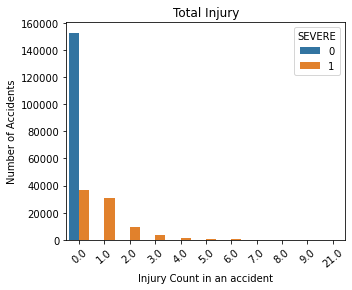

In [86]:
# counter plot of Total Injuries
plt.figure(figsize=(5,4))
sns.countplot(x="INJURIES_TOTAL", data=severity_accident_clean, hue="SEVERE")
plt.title('Total Injury')
plt.xlabel('Injury Count in an accident')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=40);

In [87]:
pd.DataFrame(severity_accident.groupby(['DAMAGE','SEVERE']).CRASH_RECORD_ID.count())

CRASH_RECORD_ID
DAMAGE        SEVERE                 
$500 OR LESS  0                 16228
              1                  5225
$501 - $1,500 0                 48131
              1                  7580
OVER $1,500   0                 88428
              1                 70666

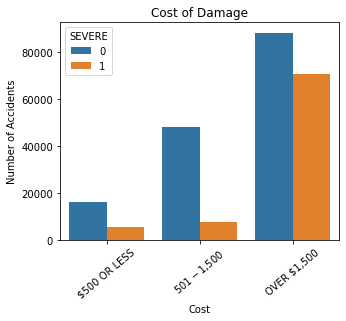

In [88]:
# DAMAGE VS SEVERITY

plt.figure(figsize=(5,4))
sns.countplot(x="DAMAGE", data=severity_accident_clean, hue="SEVERE")
plt.title('Cost of Damage')
plt.xlabel('Cost')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=40);

# Calculate the Risk Score

In [89]:
Accident_Parameters = severity_accident[['LATITUDE','LONGITUDE','LOCATION','ADDRESS','INJURIES_FATAL','INJURIES_TOTAL','DAMAGE']]

In [90]:
Accident_Parameters

,LATITUDE,LONGITUDE,LOCATION,ADDRESS,INJURIES_FATAL,INJURIES_TOTAL,DAMAGE
0,41.909977,-87.755823,POINT (-87.755822648009 41.909977009294),1614 N LARAMIE AVE,0.0,0.0,"$501 - $1,500"
1,41.797395,-87.684273,POINT (-87.684272963451 41.797394747543),5300 S WESTERN AVE,0.0,1.0,"OVER $1,500"
2,41.894049,-87.622999,POINT (-87.62299852501 41.894049259418),161 E ERIE ST,0.0,0.0,"OVER $1,500"
3,41.894049,-87.622999,POINT (-87.62299852501 41.894049259418),161 E ERIE ST,0.0,0.0,"OVER $1,500"
4,41.905033,-87.746172,POINT (-87.746171786063 41.905032966964),1324 N CICERO AVE,0.0,0.0,"$501 - $1,500"
...,...,...,...,...,...,...,...
238063,41.874004,-87.676602,POINT (-87.676602341069 41.874003638416),600 S DAMEN AVE,0.0,1.0,"OVER $1,500"
238064,41.751638,-87.564871,POINT (-87.564871437929 41.751638437521),2435 E 79TH ST,0.0,0.0,"$501 - $1,500"
238065,41.751638,-87.564871,POINT (-87.564871437929 41.751638437521),2435 E 79TH ST,0.0,0.0,"$501 - $1,500"
238066,41.721478,-87.650694,POINT (-87.650694262037 41.721478236557),1100 W 95TH ST,0.0,0.0,"OVER $1,500"


In [91]:
#INJURIES_FATAL

Accident_Parameters['INJURIES_FATAL'].unique()

Accident_Parameters['Risk_Parameter_A'] = pd.cut(x=Accident_Parameters['INJURIES_FATAL'], bins = [-1,0,1,2], 
                         labels = [0,1,1.5])

Accident_Parameters.Risk_Parameter_A.value_counts()
Accident_Parameters.Risk_Parameter_A.unique()

[0.0, 1.0, 1.5]
Categories (3, float64): [0.0 < 1.0 < 1.5]

In [92]:
#INJURIES TOTAL

Accident_Parameters['INJURIES_TOTAL'].unique()


Accident_Parameters['Risk_Parameter_B'] = pd.cut(x=Accident_Parameters['INJURIES_TOTAL'], bins = [-1,0,4,6,21], 
                         labels = [0,1,2,3])

Accident_Parameters.Risk_Parameter_B.value_counts()
Accident_Parameters.Risk_Parameter_B.unique()

[0, 1, 2, 3]
Categories (4, int64): [0 < 1 < 2 < 3]

In [93]:
#DAMAGE

Accident_Parameters['DAMAGE'].unique()


Damage_score = {'$500 OR LESS': 0,'$501 - $1,500': 1,'OVER $1,500': 2}

Accident_Parameters['Risk_Parameter_C'] = Accident_Parameters['DAMAGE']    
Accident_Parameters['Risk_Parameter_C'] = Accident_Parameters.Risk_Parameter_C.replace(Damage_score)
Accident_Parameters.Risk_Parameter_C.value_counts()

2    159094
1     55711
0     21453
Name: Risk_Parameter_C, dtype: int64

In [94]:
Accident_Parameters.head()

,LATITUDE,LONGITUDE,LOCATION,ADDRESS,INJURIES_FATAL,INJURIES_TOTAL,DAMAGE,Risk_Parameter_A,Risk_Parameter_B,Risk_Parameter_C
0,41.909977,-87.755823,POINT (-87.755822648009 41.909977009294),1614 N LARAMIE AVE,0.0,0.0,"$501 - $1,500",0.0,0,1
1,41.797395,-87.684273,POINT (-87.684272963451 41.797394747543),5300 S WESTERN AVE,0.0,1.0,"OVER $1,500",0.0,1,2
2,41.894049,-87.622999,POINT (-87.62299852501 41.894049259418),161 E ERIE ST,0.0,0.0,"OVER $1,500",0.0,0,2
3,41.894049,-87.622999,POINT (-87.62299852501 41.894049259418),161 E ERIE ST,0.0,0.0,"OVER $1,500",0.0,0,2
4,41.905033,-87.746172,POINT (-87.746171786063 41.905032966964),1324 N CICERO AVE,0.0,0.0,"$501 - $1,500",0.0,0,1


In [95]:
Accident_Parameters[['Risk_Parameter_A', 'Risk_Parameter_B', 'Risk_Parameter_C']] =Accident_Parameters[['Risk_Parameter_A', 'Risk_Parameter_B', 'Risk_Parameter_C']].astype(float)
Accident_Parameters['RISK_SCORE'] = 2*Accident_Parameters['Risk_Parameter_A'] + 1.5*Accident_Parameters['Risk_Parameter_B'] + 1.5*Accident_Parameters['Risk_Parameter_C']
Accident_Parameters['RISK_SCORE'] = Accident_Parameters['RISK_SCORE'].astype(int)

In [96]:
reg_input = Accident_Parameters[['Risk_Parameter_A','Risk_Parameter_B', 'Risk_Parameter_C']]
reg_output = Accident_Parameters['RISK_SCORE']

## Performing Regression to determine the Risk Score

In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(reg_input, reg_output, random_state=10)

In [98]:
linear_model = linear_model.LinearRegression()
linear_model.fit(X_train_reg,y_train_reg)
predicted_output = linear_model.predict(X_test_reg)
predicted_output

array([4.12804077, 2.91775521, 2.91775521, ..., 2.91775521, 2.91775521,
       1.29192955])

In [99]:
import statsmodels.api as sm

# Adding Constant for Adjusted R-square

constant = sm.add_constant(X_test_reg)
result = sm.OLS(y_test_reg, constant).fit()
print('R-squared values =',result.rsquared,'\nAdjusted R-Squared Value =', result.rsquared_adj)

R-squared values = 0.9743006427311183 
Adjusted R-Squared Value = 0.9742993373337866


In [100]:
from sklearn.metrics import mean_squared_error
import math
print('The Mean Squared Error Value is = ',mean_squared_error(y_test_reg, predicted_output))
print('The Root Mean Squared Error Value is = ',math.sqrt(mean_squared_error(y_test_reg, predicted_output)))

The Mean Squared Error Value is =  0.03941243123091162
The Root Mean Squared Error Value is =  0.19852564376148393


In [101]:
from sklearn.metrics import mean_absolute_error
print('The Mean Absolute Error Value is = ',mean_absolute_error(y_test_reg, predicted_output))

The Mean Absolute Error Value is =  0.16398049583160038


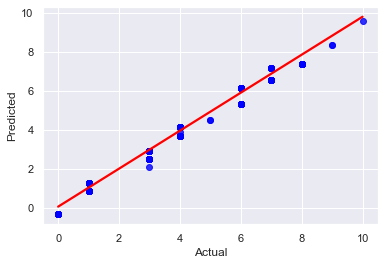

In [102]:
sns.set_theme(color_codes=True)
sns.regplot(x=y_test_reg,y=predicted_output,ci=None,scatter_kws={"color": "blue"}, line_kws={"color": "red"});
plt.xlabel('Actual');
plt.ylabel('Predicted');

In [103]:
# Identify number of time the accidents have taken place in a particular location

table = pd.pivot_table(Accident_Parameters,values='ADDRESS', index=['LOCATION','LATITUDE','LONGITUDE'],aggfunc='count')
table

,,,ADDRESS
LOCATION,LATITUDE,LONGITUDE,
POINT (-87.524587386649 41.703272315652),41.703272,-87.524587,3
POINT (-87.52467394828 41.702590432695),41.702590,-87.524674,2
POINT (-87.524720546869 41.691692338868),41.691692,-87.524721,3
POINT (-87.524748072503 41.698952907913),41.698953,-87.524748,2
POINT (-87.524790927642 41.693759814219),41.693760,-87.524791,1
...,...,...,...
POINT (-87.928221166655 41.955546694005),41.955547,-87.928221,2
POINT (-87.933993928974 41.958986950953),41.958987,-87.933994,23
POINT (-87.93450971722 42.008050932504),42.008051,-87.934510,2


In [104]:
# Making sure there are no Null Values

Accident_Parameters.drop(Accident_Parameters[Accident_Parameters['LATITUDE']==0.0].index, inplace = True)

In [105]:
Accident_Prone = copy.deepcopy(Accident_Parameters)

In [106]:
# Run only first time 
Accident_Prone = Accident_Prone.drop(columns =['INJURIES_FATAL','INJURIES_TOTAL', 'DAMAGE', 'Risk_Parameter_A', 'Risk_Parameter_B',
       'Risk_Parameter_C'],axis=1)


In [107]:
# Removing duplicate address and taking the mean of risk score of the accidents in each occuracnce

Accident_Prone = Accident_Prone.sort_values(['RISK_SCORE']).drop_duplicates(subset=['LOCATION','ADDRESS']).reset_index().drop('index',axis=1)

In [108]:
Accident_Prone

,LATITUDE,LONGITUDE,LOCATION,ADDRESS,RISK_SCORE
0,41.973130,-87.787779,POINT (-87.787778728474 41.973129833957),5037 N NAGLE AVE,0
1,41.925156,-87.676294,POINT (-87.676293521004 41.925156440725),1910 W FULLERTON AVE,0
2,41.894822,-87.755747,POINT (-87.755746863342 41.894822309693),5203 W CHICAGO AVE,0
3,41.907435,-87.687291,POINT (-87.687291422479 41.907435384743),1424 N WESTERN AVE,0
4,41.818841,-87.724113,POINT (-87.72411292982 41.818840580411),4060 S PULASKI RD,0
...,...,...,...,...,...
72676,41.881802,-87.617034,POINT (-87.617034159184 41.881802293444),13 S LAKE SHORE DR NB,7
72677,41.803086,-87.743179,POINT (-87.743178861585 41.80308551281),4928 S CICERO AVE,8
72678,41.895408,-87.706405,POINT (-87.706404595702 41.895407901235),757 N KEDZIE AVE,8
72679,41.884476,-87.693273,POINT (-87.693272523474 41.884476074976),2650 W LAKE ST,8


In [109]:
Accident_Prone = Accident_Prone.sort_values(['RISK_SCORE']).drop_duplicates(subset=['LOCATION','ADDRESS']).reset_index().drop('index',axis=1)

In [110]:
Accident_Prone = Accident_Prone.groupby(['LATITUDE','LONGITUDE','LOCATION','ADDRESS']).RISK_SCORE.mean().reset_index().sort_values(['RISK_SCORE']).reset_index().drop('index',axis=1)
Accident_Prone

,LATITUDE,LONGITUDE,LOCATION,ADDRESS,RISK_SCORE
0,41.751937,-87.559164,POINT (-87.559164441365 41.751936931709),2658 E 79TH ST,0.0
1,41.866555,-87.685890,POINT (-87.685889678053 41.866555356935),1201 S WESTERN AVE,0.0
2,41.774742,-87.612947,POINT (-87.612947221978 41.774741663786),6601 S MARQUETTE RD,0.0
3,41.774738,-87.613240,POINT (-87.613240463362 41.774738328394),6600 S MARQUETTE RD,0.0
4,41.774708,-87.739798,POINT (-87.739797521765 41.774708227681),4701 W 65TH ST,0.0
...,...,...,...,...,...
72676,41.880890,-87.721388,POINT (-87.721388487921 41.880889879848),3814 W MADISON ST,7.0
72677,41.803086,-87.743179,POINT (-87.743178861585 41.80308551281),4928 S CICERO AVE,8.0
72678,41.895408,-87.706405,POINT (-87.706404595702 41.895407901235),757 N KEDZIE AVE,8.0
72679,41.884476,-87.693273,POINT (-87.693272523474 41.884476074976),2650 W LAKE ST,8.0


# C) Provide Safer Route Based on the accident and Road Traffic Violation

In [111]:
Risky_Areas = Accident_Prone[Accident_Prone['RISK_SCORE']>=5]
Cautious_Areas = Accident_Prone[(Accident_Prone['RISK_SCORE']<5)&(Accident_Prone['RISK_SCORE']>=3)]
Safe_Areas = Accident_Prone[Accident_Prone['RISK_SCORE']<3]

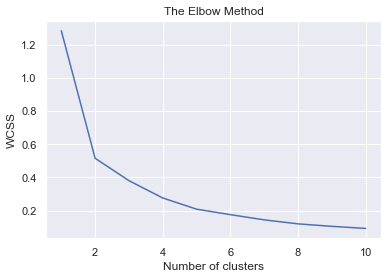

In [112]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from itertools import cycle
import matplotlib.pyplot as plt
import matplotlib.cm as cm


A = Risky_Areas.iloc[:, 0:2].values
# Using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans_A = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_A.fit(A)
    wcss.append(kmeans_A.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

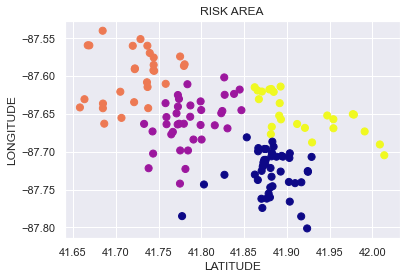

In [113]:
# Risk Area

kmeans_AA = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
y_kmeans_A = kmeans_AA.fit_predict(A)



Risky_Areas['CLUSTERS'] = y_kmeans_A +1


plt.scatter(A[:, 0], A[:, 1], c=y_kmeans_A, s=50, cmap='plasma')
centers_A = kmeans_AA.cluster_centers_

plt.title('RISK AREA')
plt.xlabel('LATITUDE')
plt.ylabel('LONGITUDE');

In [114]:
Risky_Areas

,LATITUDE,LONGITUDE,LOCATION,ADDRESS,RISK_SCORE,CLUSTERS
72547,41.871766,-87.719561,POINT (-87.71956135568 41.87176574478),727 S INDEPENDENCE BLVD,5.0,1
72548,41.866629,-87.695098,POINT (-87.695098090954 41.866629331397),2740 W ROOSEVELT RD,5.0,1
72549,41.872511,-87.717937,POINT (-87.717936582806 41.872511350085),3659 W FLOURNOY ST,5.0,1
72550,41.737164,-87.614399,POINT (-87.614398725718 41.737163690854),8639 S DR MARTIN LUTHER KING JR DR,5.0,3
72551,41.882330,-87.666983,POINT (-87.666982753227 41.882329582242),32 N ASHLAND AVE,6.0,4
...,...,...,...,...,...,...
72676,41.880890,-87.721388,POINT (-87.721388487921 41.880889879848),3814 W MADISON ST,7.0,1
72677,41.803086,-87.743179,POINT (-87.743178861585 41.80308551281),4928 S CICERO AVE,8.0,1
72678,41.895408,-87.706405,POINT (-87.706404595702 41.895407901235),757 N KEDZIE AVE,8.0,1
72679,41.884476,-87.693273,POINT (-87.693272523474 41.884476074976),2650 W LAKE ST,8.0,1


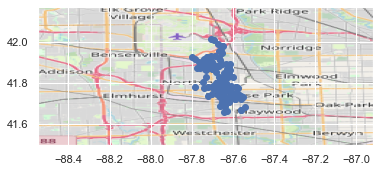

In [115]:

# The boundaries of the image map
map_box = [-88.5471, -86.9183, 41.4962, 42.1705]
# The name of the image of the New York map might be different.
map_img = plt.imread('C:/Users/mural/Desktop/Traffic dataset/Updated ones/chicago_map_3.png')
fig, ax = plt.subplots()
ax.scatter(Risky_Areas['LONGITUDE'],Risky_Areas['LATITUDE'])
ax.set_ylim(map_box[2], map_box[3])
ax.set_xlim(map_box[0], map_box[1])
ax.imshow(map_img, extent=map_box, alpha=1)

plt.savefig("Risk_Factor.png")
plt.show()

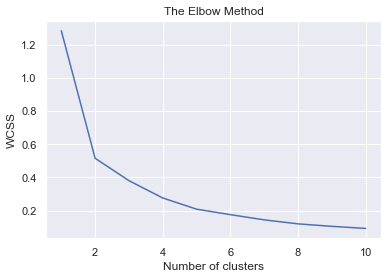

In [116]:
B = Cautious_Areas.iloc[:, 0:2].values
# Using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans_B = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_B.fit(A)
    wcss.append(kmeans_B.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

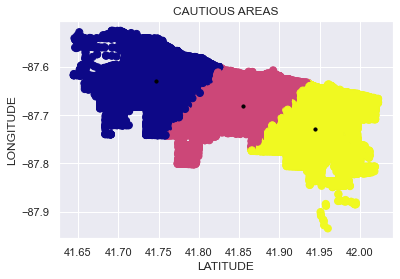

In [117]:
#Cautious Area

kmeans_BB = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans_B = kmeans_BB.fit_predict(B)

plt.scatter(B[:, 0], B[:, 1], c=y_kmeans_B, s=50, cmap='plasma')

Cautious_Areas['CLUSTERS'] = y_kmeans_B +1

centers_B = kmeans_BB.cluster_centers_
plt.scatter(centers_B[:, 0], centers_B[:, 1], color='BLACK', s=10, alpha=1);


plt.title('CAUTIOUS AREAS')
plt.xlabel('LATITUDE')
plt.ylabel('LONGITUDE');

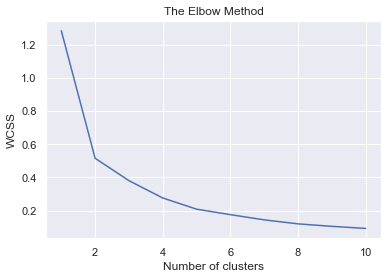

In [118]:
C = Safe_Areas.iloc[:, 0:2].values
# Using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans_C = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_C.fit(A)
    wcss.append(kmeans_C.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

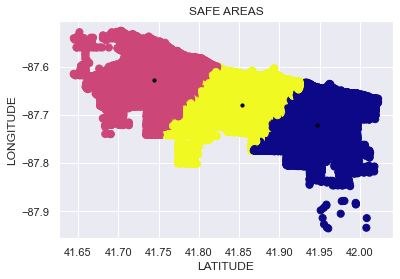

In [119]:
#Safe Area

kmeans_CC = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans_C = kmeans_CC.fit_predict(C)
# 1.3 map data back to df
# Accident_Prone['CLUSTERS'] = y_kmeans +1 # to step up to group 1 to 3
plt.scatter(C[:, 0], C[:, 1], c=y_kmeans_C, s=50, cmap='plasma')

centers_C = kmeans_CC.cluster_centers_

Safe_Areas['CLUSTERS'] = y_kmeans_C +1

plt.title('SAFE AREAS')
plt.xlabel('LATITUDE')
plt.ylabel('LONGITUDE');
plt.scatter(centers_C[:, 0], centers_C[:, 1], color='BLACK', s=10, alpha=1);

In [120]:
Safe_Areas

,LATITUDE,LONGITUDE,LOCATION,ADDRESS,RISK_SCORE,CLUSTERS
0,41.751937,-87.559164,POINT (-87.559164441365 41.751936931709),2658 E 79TH ST,0.0,2
1,41.866555,-87.685890,POINT (-87.685889678053 41.866555356935),1201 S WESTERN AVE,0.0,3
2,41.774742,-87.612947,POINT (-87.612947221978 41.774741663786),6601 S MARQUETTE RD,0.0,2
3,41.774738,-87.613240,POINT (-87.613240463362 41.774738328394),6600 S MARQUETTE RD,0.0,2
4,41.774708,-87.739798,POINT (-87.739797521765 41.774708227681),4701 W 65TH ST,0.0,3
...,...,...,...,...,...,...
27801,41.751682,-87.704733,POINT (-87.704733070226 41.751682223611),7759 S SPAULDING AVE,1.0,2
27802,41.758649,-87.593374,POINT (-87.593374155881 41.758649291065),7500 S KIMBARK AVE,1.0,2
27803,41.751658,-87.605362,POINT (-87.605362007712 41.751657898722),7848 S COTTAGE GROVE AVE,1.0,2
27804,41.735786,-87.671647,POINT (-87.671646706386 41.735785509577),1932 W 87TH ST,1.0,2


Text(0, 0.5, 'WCSS')

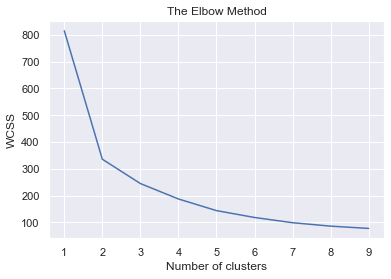

In [121]:
X = Accident_Prone.iloc[:, 0:2].values
# Using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

In [122]:
Accident_Prone

,LATITUDE,LONGITUDE,LOCATION,ADDRESS,RISK_SCORE
0,41.751937,-87.559164,POINT (-87.559164441365 41.751936931709),2658 E 79TH ST,0.0
1,41.866555,-87.685890,POINT (-87.685889678053 41.866555356935),1201 S WESTERN AVE,0.0
2,41.774742,-87.612947,POINT (-87.612947221978 41.774741663786),6601 S MARQUETTE RD,0.0
3,41.774738,-87.613240,POINT (-87.613240463362 41.774738328394),6600 S MARQUETTE RD,0.0
4,41.774708,-87.739798,POINT (-87.739797521765 41.774708227681),4701 W 65TH ST,0.0
...,...,...,...,...,...
72676,41.880890,-87.721388,POINT (-87.721388487921 41.880889879848),3814 W MADISON ST,7.0
72677,41.803086,-87.743179,POINT (-87.743178861585 41.80308551281),4928 S CICERO AVE,8.0
72678,41.895408,-87.706405,POINT (-87.706404595702 41.895407901235),757 N KEDZIE AVE,8.0
72679,41.884476,-87.693273,POINT (-87.693272523474 41.884476074976),2650 W LAKE ST,8.0


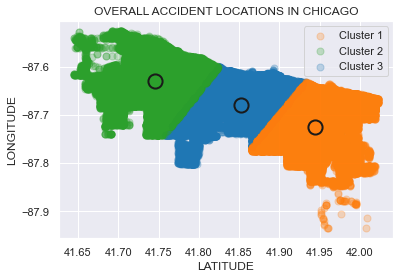

In [123]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from itertools import cycle
import matplotlib.pyplot as plt
import matplotlib.cm as cm
n_clusters = 3
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_
#Clusters in DataFrame
Accident_Prone['CLUSTERS'] = y_kmeans +1 # to step up to group 1 to 3
labels = {1: "Cluster 1", 2: "Cluster 2", 0: "Cluster 3"}
colors = cycle(cm.tab10.colors)
plt.figure()
for i in range(n_clusters):
    # plot one cluster for each iteration
    color = next(colors)
    # find indeces corresponding to cluser i
    idx = y_kmeans == i
    # plot cluster
    plt.scatter(X[idx, 0], X[idx, 1], color=color, s=50, label=labels[i], alpha=0.25)
    # plot center
    plt.scatter(centers[i, 0], centers[i, 1], edgecolors="k", linewidth=2, color=color, s=200, alpha=1)
    
#Arranging the Legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.title('OVERALL ACCIDENT LOCATIONS IN CHICAGO')
plt.xlabel('LATITUDE')
plt.ylabel('LONGITUDE');

In [124]:
# Forming 9 Areas using the Risk score values and clusters

Area_1A = Accident_Prone[(Accident_Prone['CLUSTERS']==1) & (Accident_Prone['RISK_SCORE']>=5)]
Area_1B = Accident_Prone[(Accident_Prone['CLUSTERS']==1) & (Accident_Prone['RISK_SCORE']<5) & (Accident_Prone['RISK_SCORE']>=3)]
Area_1C = Accident_Prone[(Accident_Prone['CLUSTERS']==1) & (Accident_Prone['RISK_SCORE']<3)]

Area_2A = Accident_Prone[(Accident_Prone['CLUSTERS']==2) & (Accident_Prone['RISK_SCORE']>=5)]
Area_2B = Accident_Prone[(Accident_Prone['CLUSTERS']==2) & (Accident_Prone['RISK_SCORE']<5) & (Accident_Prone['RISK_SCORE']>=3)]
Area_2C = Accident_Prone[(Accident_Prone['CLUSTERS']==2) & (Accident_Prone['RISK_SCORE']<3)]

Area_3A = Accident_Prone[(Accident_Prone['CLUSTERS']==3) & (Accident_Prone['RISK_SCORE']>=5)]
Area_3B = Accident_Prone[(Accident_Prone['CLUSTERS']==3) & (Accident_Prone['RISK_SCORE']<5) & (Accident_Prone['RISK_SCORE']>=3)]
Area_3C = Accident_Prone[(Accident_Prone['CLUSTERS']==3) & (Accident_Prone['RISK_SCORE']<3)]

In [125]:
Area_2A

,LATITUDE,LONGITUDE,LOCATION,ADDRESS,RISK_SCORE,CLUSTERS
72555,41.916889,-87.740278,POINT (-87.740277928518 41.916888680909),4537 W ARMITAGE AVE,6.0,2
72557,42.008672,-87.690311,POINT (-87.690310838299 42.008671587187),7000 N WESTERN AVE,6.0,2
72558,41.990901,-87.673136,POINT (-87.673136023888 41.990900768001),1736 W PETERSON AVE,6.0,2
72571,41.880584,-87.747053,POINT (-87.747052941385 41.880583885354),4848 W MADISON ST,6.0,2
72573,41.892722,-87.726149,POINT (-87.726149344028 41.892722092718),632 N PULASKI RD,6.0,2
72581,41.909573,-87.741428,POINT (-87.74142821104 41.909573033239),4601 W NORTH AVE,6.0,2
72584,41.871325,-87.774192,POINT (-87.774192049944 41.8713251911),699 S AUSTIN BLVD,6.0,2
72594,41.923660,-87.801244,POINT (-87.801243587929 41.923660032932),7010 W GRAND AVE,6.0,2
72595,41.977066,-87.650297,POINT (-87.650297416 41.977065592454),5213 N LAKE SHORE DR NB,6.0,2
72598,42.013827,-87.704560,POINT (-87.704559952014 42.013826633311),7300 N SACRAMENTO AVE,6.0,2


In [126]:
# Starting Co-ordinates


start_lat = 41.88707
start_long = -87.6478


# Ending Co-ordinates

end_lat = 41.7766541 
end_long = -87.658113 


# start_latlng = (Longitude,Lattitude)
start_location = [start_long,start_lat]

# end_latlng  = (Longitude,Lattitude)
end_location = [end_long,end_lat]


coordinates = start_location,end_location
list(coordinates)

[[-87.6478, 41.88707], [-87.658113, 41.7766541]]

In [127]:
# Each Center of Clusters are used to find the distance between the start and end co-ordinated to the clusters
cluster_1_center = centers[0]
cluster_2_center = centers[1]
cluster_3_center = centers[2]

In [128]:
# define the start and end locations in latlng

from geopy.geocoders import Nominatim
from geopy.distance import distance as gd


start_latlng =(start_lat,start_long)
end_latlng = (end_lat,end_long)

start_len1 = gd(start_latlng, cluster_1_center).km
start_len2 = gd(start_latlng, cluster_2_center).km
start_len3 = gd(start_latlng, cluster_3_center).km

if (start_len1 <= start_len2) and (start_len1 <= start_len3):
    print("The Start point is closer to Cluster 1 and the distance is",start_len1,'KM')
elif (start_len2 <= start_len1) and (start_len2 <= start_len3):
    print("The Start point is closer to Cluster 2 and the distance is",start_len2,'KM')
else:
    print("The Start point is closer to Cluster 3 and the distance is",start_len3,'KM')


end_len1 = gd(end_latlng, cluster_1_center).km
end_len2 = gd(end_latlng, cluster_2_center).km
end_len3 = gd(end_latlng, cluster_3_center).km

if (end_len1 <= end_len2) and (end_len1 <= end_len3):
    print("The End point is closer to Cluster 1 and the distance is",end_len1,'KM')
elif (end_len2 <= end_len1) and (end_len2 <= end_len3):
    print("The End point is closer to Cluster 2 and the distance is",end_len2,'KM')
else:
    print("The End point is closer to Cluster 3 and the distance is",end_len3,'KM')


The Start point is closer to Cluster 1 and the distance is 4.649928796483273 KM
The End point is closer to Cluster 3 and the distance is 4.281230512403294 KM


In [129]:
#Identifying the risk cluster which is closer to start and end locations

if (start_len1 <= start_len2) and (start_len1 <= start_len3):
    Risky_Area_1 = Area_1A
elif (start_len2 <= start_len1) and (start_len2 <= start_len3):
    Risky_Area_1 = Area_2A
else:
    Risky_Area_1 = Area_3A
    
    
if (end_len1 <= end_len2) and (end_len1 <= end_len3):
    Risky_Area_2 = Area_1A
elif (end_len2 <= end_len1) and (end_len2 <= end_len3):
    Risky_Area_2 = Area_2A
else:
    Risky_Area_2 = Area_3A
    
    
if pd.DataFrame.equals(Risky_Area_1, Risky_Area_2):
    
    Risky_Areas = Risky_Area_1
else:
    Risky_Areas = Risky_Area_1.append(Risky_Area_2, ignore_index = True)
    
Risky_Areas

,LATITUDE,LONGITUDE,LOCATION,ADDRESS,RISK_SCORE,CLUSTERS
0,41.871766,-87.719561,POINT (-87.71956135568 41.87176574478),727 S INDEPENDENCE BLVD,5.0,1
1,41.866629,-87.695098,POINT (-87.695098090954 41.866629331397),2740 W ROOSEVELT RD,5.0,1
2,41.872511,-87.717937,POINT (-87.717936582806 41.872511350085),3659 W FLOURNOY ST,5.0,1
3,41.882330,-87.666983,POINT (-87.666982753227 41.882329582242),32 N ASHLAND AVE,6.0,1
4,41.882528,-87.701393,POINT (-87.701393161617 41.882527800937),50 N SACRAMENTO BLVD,6.0,1
...,...,...,...,...,...,...
100,41.686564,-87.662869,POINT (-87.662869160448 41.686563935329),11400 S MARSHFIELD AVE,7.0,3
101,41.766732,-87.673704,POINT (-87.673703972815 41.766731857123),2000 W 70TH ST,7.0,3
102,41.779603,-87.662939,POINT (-87.662939134453 41.779602725472),1530 W 63RD ST,7.0,3
103,41.772617,-87.624980,POINT (-87.62498023065 41.772616823648),3 E MARQUETTE RD,7.0,3


# NAVIGATION MODEL USING OPEN ROUTE SERVICE

In [130]:
# The idea behind using the below code is given in the link below
# https://openrouteservice.org/example-avoid-obstacles-while-routing/

In [131]:
#Round 1
# Normal Route

import folium
import pyproj
import requests
from openrouteservice import client
from shapely import geometry
from shapely.geometry import Point, LineString, Polygon, MultiPolygon


#API KEY
api_key = '5b3ce3597851110001cf62484a0bee2bedfa4902bd8e3af3987cd5df'

ors_client = client.Client(key=api_key)

# profile = ( driving-car, driving-hgv, foot-walking, foot-hiking, cycling-regular,
# cycling-road, cycling-mountain, cycling-electric )

route_normal = ors_client.directions(coordinates=coordinates,
                          profile='driving-car',
                          format='geojson')

def style_function_A(feature):
    return {'opacity': 5, 
            'weight': 3, 
            'color':'RED'} 

Normal_Navigation = folium.Map(location=[41.8781, -87.6798], zoom_start=11)

# add geojson to map
folium.GeoJson(route_normal, name='Normal Route',style_function= style_function_A,overlay=True).add_to(Normal_Navigation)

folium.Marker(list(start_latlng),popup=coordinates[0],icon=folium.Icon(color='orange', icon='home')).add_to(Normal_Navigation)
folium.Marker(list(end_latlng),popup=coordinates[1],icon=folium.Icon(color='black', icon='home')).add_to(Normal_Navigation)



# add layer control to map (allows layer to be turned on or off)
folium.TileLayer('openstreetmap').add_to(Normal_Navigation)
folium.TileLayer('Stamen Terrain').add_to(Normal_Navigation)
folium.TileLayer('Stamen Toner').add_to(Normal_Navigation)
folium.TileLayer('Stamen Water Color').add_to(Normal_Navigation)
folium.TileLayer('cartodbpositron').add_to(Normal_Navigation)
folium.TileLayer('cartodbdark_matter').add_to(Normal_Navigation)
folium.LayerControl().add_to(Normal_Navigation)

# display map
Normal_Navigation

In [132]:
# distance in Miles and duration in Hours

print(route_normal['features'][0]['properties']['segments'][0]['distance']*0.000621371, 'miles')
print(route_normal['features'][0]['properties']['segments'][0]['duration']*0.000277778, 'hours\n')

9.5402196485 miles
0.2885002308 hours



In [133]:
# Distances are in meters
# Timings are in seconds
print('directions')
for index, i in enumerate(route_normal['features'][0]['properties']['segments'][0]['steps']):
    print(index+1, i, '\n')

directions
1 {'distance': 156.7, 'duration': 30.4, 'type': 11, 'instruction': 'Head south on North Halsted Street', 'name': 'North Halsted Street', 'way_points': [0, 11]} 

2 {'distance': 101.5, 'duration': 14.6, 'type': 0, 'instruction': 'Turn left onto West Lake Street', 'name': 'West Lake Street', 'way_points': [11, 15]} 

3 {'distance': 315.0, 'duration': 44.1, 'type': 13, 'instruction': 'Keep right', 'name': '-', 'way_points': [15, 25]} 

4 {'distance': 93.0, 'duration': 11.2, 'type': 6, 'instruction': 'Continue straight onto Kennedy Expressway, I 90, I 94', 'name': 'Kennedy Expressway, I 90, I 94', 'way_points': [25, 27]} 

5 {'distance': 2247.7, 'duration': 179.6, 'type': 12, 'instruction': 'Keep left onto Kennedy Expressway, I 90, I 94', 'name': 'Kennedy Expressway, I 90, I 94', 'way_points': [27, 53]} 

6 {'distance': 2103.5, 'duration': 75.7, 'type': 6, 'instruction': 'Continue straight onto Dan Ryan Expressway, I 90, I 94', 'name': 'Dan Ryan Expressway, I 90, I 94', 'way_poi

## Navigation to avoid risk areas

In [134]:
#Getting the risky locations in the clusters that are closer to the start and end point

Risk_factor = [[LONGITUDE, LATITUDE] for LONGITUDE, LATITUDE in zip(Risky_Areas['LONGITUDE'],Risky_Areas['LATITUDE'])]

In [135]:
# Creating a polygon Perimeter using the risk areas near the navigation area

import folium
import pyproj
import requests 
from openrouteservice import client
from shapely import geometry
from shapely.geometry import Point, LineString, Polygon, MultiPolygon


#API KEY
api_key = '5b3ce3597851110001cf62484a0bee2bedfa4902bd8e3af3987cd5df'

ors_client = client.Client(key=api_key)

def risk_buffer_polygon(point_in, resolution=10, radius=5):
    convert = pyproj.Transformer.from_crs("epsg:4326", 'epsg:32632')  # epsg:4326 to epsg:32632
    convert_back = pyproj.Transformer.from_crs('epsg:32632', "epsg:4326")  #  epsg:32632 to epsg:4326
    point_in_proj = convert.transform(*point_in)
    point_buffer_proj = Point(point_in_proj).buffer(radius, resolution=resolution)  # 10 m buffer

    # Iterate over all points in buffer and build polygon
    RISK_POLYGON = []
    for point in point_buffer_proj.exterior.coords:
        RISK_POLYGON.append(convert_back.transform(*point)) # Transform back to epsg:4326
    
    return RISK_POLYGON

In [136]:
#Folium (lat,long)

#open_street(long,lat)

map_parameters = {'tiles': 'openstreetmap',
              'location': ([41.881832, -87.623177]),
              'zoom_start': 11}
risk_area_location = folium.Map(**map_parameters)

# Populate a construction site buffer polygon list
RISK_POLYGON = []
for risk in Risk_factor:
    site_coords = risk
    folium.features.Marker(list(reversed(site_coords)),
                           popup='Risk_Area<br>{0}'.format(site_coords)).add_to(risk_area_location)

    # Create buffer polygons around construction sites with 10 m radius and low resolution
    risk_poly_cords = risk_buffer_polygon(site_coords,
                                             resolution=1,  # low resolution to keep polygons lean
                                             radius=5)
    RISK_POLYGON.append(risk_poly_cords)

    risk_poly_cords = [(y, x) for x, y in risk_poly_cords]  # Reverse coords for folium/Leaflet
    folium.vector_layers.Polygon(locations=risk_poly_cords,
                                 color='#ffd699',
                                 fill_color='#ffd699',
                                 fill_opacity=0.2,
                                 weight=3).add_to(risk_area_location)
folium.TileLayer('openstreetmap').add_to(risk_area_location)
folium.TileLayer('Stamen Terrain').add_to(risk_area_location)
folium.TileLayer('Stamen Toner').add_to(risk_area_location)
folium.TileLayer('Stamen Water Color').add_to(risk_area_location)
folium.TileLayer('cartodbpositron').add_to(risk_area_location)
folium.TileLayer('cartodbdark_matter').add_to(risk_area_location)
folium.LayerControl().add_to(risk_area_location)
    
risk_area_location

In [137]:
import folium
import pyproj
import requests 
from openrouteservice import client
from shapely import geometry
from shapely.geometry import Point, LineString, Polygon, MultiPolygon


def style_function(color):
    return lambda feature: dict(color=color,
                                weight=3,
                                opacity=0.5)



map_parameters.update({'location': ([41.881832, -87.623177]),
                   'zoom_start': 11})
Desired_Nagiation_System = folium.Map(**map_parameters)


# Using the Normal Route Map which was done before and comparing with the risk free route

def style_function_B(feature):
    return {'opacity': 5, 
            'weight': 3, 
            'color':'RED'}

folium.features.GeoJson(data=route_normal,
                        name='Normal Route',
                        style_function=style_function_B,
                        overlay=True).add_to(Desired_Nagiation_System)


# Eliminating Risky areas which are not in the immediate surrounding of the route of interest
# With Buffer value of 0.009 degrees covers area aroud


def style_function_D(feature):
    return {'opacity': 5, 
            'weight': 3, 
            'color':'GREEN'}


route_buffer = LineString(route_normal['features'][0]['geometry']['coordinates']).buffer(0.009)
folium.features.GeoJson(data=geometry.mapping(route_buffer),
                        name='Route Buffer',
                        style_function=style_function_D,
                        overlay=True).add_to(Desired_Nagiation_System)



# Plot which construction sites fall into the buffer Polygon
sites_buffer_poly = []
for RISK_POLYGON in RISK_POLYGON:
    poly = Polygon(RISK_POLYGON)
    if route_buffer.intersects(poly):
        folium.features.Marker(list(reversed(poly.centroid.coords[0]))).add_to(Desired_Nagiation_System)
        sites_buffer_poly.append(poly)



# Route which avoids accident prone areas

# Request normal route between appropriate locations without construction sites
request_params = {'coordinates': list(coordinates),
                  'format_out': 'geojson',
                  'profile': 'driving-car',
                  'preference': 'shortest',
                  'instructions': 'true',}

request_params['options'] = {'avoid_polygons': geometry.mapping(MultiPolygon(sites_buffer_poly))}
route_detour = ors_client.directions(**request_params)

def style_function_C(feature):
    return {'opacity': 5, 
            'weight': 3, 
            'color':'BLUE'}


route_detour = ors_client.directions(**request_params)
folium.features.GeoJson(data=route_detour,
                        name='Risk Free Route',
                        style_function=style_function_C,
                        overlay=True).add_to(Desired_Nagiation_System)


folium.Marker(list(start_latlng),popup=coordinates[0],icon=folium.Icon(color='orange', icon='home'),color="blue").add_to(Desired_Nagiation_System)
folium.Marker(list(end_latlng),popup=coordinates[1],icon=folium.Icon(color='black', icon='home'),color="red").add_to(Desired_Nagiation_System)
    

        
folium.TileLayer('openstreetmap').add_to(Desired_Nagiation_System)
folium.TileLayer('Stamen Terrain').add_to(Desired_Nagiation_System)
folium.TileLayer('Stamen Toner').add_to(Desired_Nagiation_System)
folium.TileLayer('Stamen Water Color').add_to(Desired_Nagiation_System)
folium.TileLayer('cartodbpositron').add_to(Desired_Nagiation_System)
folium.TileLayer('cartodbdark_matter').add_to(Desired_Nagiation_System)
folium.LayerControl().add_to(Desired_Nagiation_System)


Desired_Nagiation_System

## Normal Route vs Detour Route

In [138]:

# Normal Route


# distance in Miles and duration in Hours

print("The total distance travelled in the normal route is",route_normal['features'][0]['properties']['segments'][0]['distance']*0.000621371, 'miles')
print("The total Time Taken to travel in the normal route is",route_normal['features'][0]['properties']['segments'][0]['duration']*0.000277778*60, 'Minutes\n')



# Distances are in meters
# Timings are in seconds
print('DIRECTIONS: \n')
for index, i in enumerate(route_normal['features'][0]['properties']['segments'][0]['steps']):
    print(index+1, i, '\n')

The total distance travelled in the normal route is 9.5402196485 miles
The total Time Taken to travel in the normal route is 17.310013847999997 Minutes

DIRECTIONS: 

1 {'distance': 156.7, 'duration': 30.4, 'type': 11, 'instruction': 'Head south on North Halsted Street', 'name': 'North Halsted Street', 'way_points': [0, 11]} 

2 {'distance': 101.5, 'duration': 14.6, 'type': 0, 'instruction': 'Turn left onto West Lake Street', 'name': 'West Lake Street', 'way_points': [11, 15]} 

3 {'distance': 315.0, 'duration': 44.1, 'type': 13, 'instruction': 'Keep right', 'name': '-', 'way_points': [15, 25]} 

4 {'distance': 93.0, 'duration': 11.2, 'type': 6, 'instruction': 'Continue straight onto Kennedy Expressway, I 90, I 94', 'name': 'Kennedy Expressway, I 90, I 94', 'way_points': [25, 27]} 

5 {'distance': 2247.7, 'duration': 179.6, 'type': 12, 'instruction': 'Keep left onto Kennedy Expressway, I 90, I 94', 'name': 'Kennedy Expressway, I 90, I 94', 'way_points': [27, 53]} 

6 {'distance': 2103.

In [139]:

# Alternative Risk Free Route


# distance in Miles and duration in Hours

print("The total distance travelled in the detour route is",route_detour['features'][0]['properties']['segments'][0]['distance']*0.000621371, 'miles')
print("The total Time Taken to travel in the detour route is",route_detour['features'][0]['properties']['segments'][0]['duration']*0.000277778*60, 'Minutes\n')



# Distances are in meters
# Timings are in seconds
print('DIRECTIONS: \n')
for index, i in enumerate(route_detour['features'][0]['properties']['segments'][0]['steps']):
    print(index+1, i, '\n')

The total distance travelled in the detour route is 8.2608788966 miles
The total Time Taken to travel in the detour route is 32.468359308000004 Minutes

DIRECTIONS: 

1 {'distance': 4435.5, 'duration': 599.0, 'type': 11, 'instruction': 'Head south on North Halsted Street', 'name': 'North Halsted Street', 'way_points': [0, 192]} 

2 {'distance': 107.4, 'duration': 18.5, 'type': 1, 'instruction': 'Turn right onto South Archer Avenue', 'name': 'South Archer Avenue', 'way_points': [192, 195]} 

3 {'distance': 650.8, 'duration': 70.9, 'type': 5, 'instruction': 'Turn slight right onto South Archer Avenue', 'name': 'South Archer Avenue', 'way_points': [195, 211]} 

4 {'distance': 45.7, 'duration': 11.0, 'type': 0, 'instruction': 'Turn left onto South Throop Street', 'name': 'South Throop Street', 'way_points': [211, 214]} 

5 {'distance': 256.1, 'duration': 46.1, 'type': 1, 'instruction': 'Turn right', 'name': '-', 'way_points': [214, 232]} 

6 {'distance': 181.6, 'duration': 32.7, 'type': 0,